<a href="https://colab.research.google.com/github/Louisrum/etcs/blob/claude%2Ftim-collaboration-01JBXQsWrrdB1rH42JAb7uYK/assignment_timesires2_electric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚡ 전력 소비 데이터 시계열 분석 종합 과제

> **목표**: 전력 소비 데이터를 활용하여 전처리부터 다양한 모델(전통 통계 모델 + 딥러닝 + Foundation 모델)까지 전체 시계열 분석 프로세스를 학습합니다.

## 학습 목표

1. **시계열 데이터 전처리**: 결측치 처리, 특성 공학
2. **정상성 검정 및 확보**: ADF/KPSS 검정, 차분
3. **전통 통계 모델**: ARIMA, SARIMA, Holt-Winters, VAR
4. **RNN 계열 모델**: Simple RNN, LSTM, GRU
5. **Attention 메커니즘**: LSTM + Attention
6. **Transformer 기반**: TFT (Temporal Fusion Transformer)
7. **Foundation 모델**: Chronos (Zero-shot 예측)
8. **모델 성능 비교**: 각 모델의 장단점 이해

## 사용 데이터

**UCI 전력 부하 데이터셋 (LD2011_2014)**
- 370명 사용자의 전력 소비량 (kW)
- 2011-2014년, 15분 빈도
- 시간별로 집계하여 사용

---

# Part 0. 환경 설정

In [1]:
# 필요한 라이브러리 설치
!pip install torch pytorch-lightning pytorch-forecasting -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 34.6 MB/s eta 0:00:00


In [2]:
# 한글 폰트 설치 및 설정 (Colab/로컬 환경 모두 지원)
import subprocess
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Colab 환경 확인
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Colab: 나눔 폰트 설치
    subprocess.run(['apt-get', 'install', '-y', 'fonts-nanum'], capture_output=True)
    subprocess.run(['fc-cache', '-fv'], capture_output=True)

    # 폰트 캐시 강제 재구축
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    if os.path.exists(font_path):
        fm.fontManager.addfont(font_path)
        plt.rcParams['font.family'] = 'NanumGothic'
    else:
        # 대체 폰트 사용
        plt.rcParams['font.family'] = 'DejaVu Sans'
else:
    # 로컬 환경: OS별 폰트 설정
    import platform
    system = platform.system()

    if system == 'Windows':
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif system == 'Darwin':  # macOS
        plt.rcParams['font.family'] = 'AppleGothic'
    else:  # Linux
        # 나눔고딕 폰트 확인
        nanum_fonts = [f for f in fm.findSystemFonts() if 'nanum' in f.lower()]
        if nanum_fonts:
            fm.fontManager.addfont(nanum_fonts[0])
            plt.rcParams['font.family'] = 'NanumGothic'
        else:
            plt.rcParams['font.family'] = 'DejaVu Sans'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print(f"현재 폰트: {plt.rcParams['font.family']}")
print("✅ 폰트 설정 완료!")

현재 폰트: ['NanumGothic']
✅ 폰트 설정 완료!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 시계열 분석 라이브러리
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# 딥러닝 라이브러리
import torch
import torch.nn as nn

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


---

# Part 1. 데이터 로드 및 전처리

## 1.1 데이터 로드

UCI 전력 데이터셋을 로드합니다. Google Drive에 데이터를 넣어주세요

In [7]:
# Google Colab 환경에서 Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 데이터 경로 설정 (본인의 경로에 맞게 수정하세요)
DATA_PATH = '/content/drive/MyDrive/advanced/session08/LD2011_2014.txt'

# 데이터 로드
data_raw = pd.read_csv(DATA_PATH, index_col=0, sep=';', decimal=',')
data_raw.index = pd.to_datetime(data_raw.index)
data_raw.sort_index(inplace=True)

print(f"원본 데이터 shape: {data_raw.shape}")
print(f"데이터 기간: {data_raw.index.min()} ~ {data_raw.index.max()}")
print(f"\n처음 5행:")
data_raw.head()

원본 데이터 shape: (90716, 370)
데이터 기간: 2011-01-01 00:15:00 ~ 2013-08-02 23:00:00

처음 5행:


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.2 데이터 전처리

### 1.2.1 시간별 집계 및 단일 사용자 선택

15분 간격 데이터를 시간별로 집계하고, 분석을 위해 단일 사용자(MT_004)를 선택합니다.

**작업 내용:**
- 원본 데이터를 **시간별(1h)로 리샘플링**하여 집계합니다.
- 분석할 **단일 사용자를 선택**합니다.
- 전력 사용량이 0인 값을 **결측치(NaN)로 변환**합니다.

**주요 함수:**
- `resample('1h')`: 시계열 데이터를 1시간 단위로 재집계
- `mean()`: 각 시간 구간의 평균값 계산
- `replace()`: 특정 값을 다른 값으로 대체

In [11]:
# 시간별 평균으로 리샘플링
# 힌트: data_raw.resample('주기').집계함수()
data_hourly = data_raw.resample('1h').mean()

# 단일 사용자 선택 (MT_002: 분석 대상 사용자)
user_id = 'MT_002'
ts = data_hourly[user_id].copy()

# 0 값을 NaN으로 변환 (전력 사용량 0은 결측으로 간주)
# 힌트: 시리즈.replace(기존값, 새로운값)
ts = ts.replace(0., np.nan)

print(f"선택된 사용자: {user_id}")
print(f"데이터 크기: {len(ts)}")
print(f"결측치 개수: {ts.isna().sum()}")
print(f"결측치 비율: {ts.isna().sum()/len(ts)*100:.2f}%")

선택된 사용자: MT_002
데이터 크기: 22680
결측치 개수: 8760
결측치 비율: 38.62%


### 1.2.2 결측치 처리 및 분석 기간 선택

**작업 내용:**
- 데이터의 **유효한 범위**를 찾아 앞뒤 결측이 많은 부분을 제거합니다.
- 남은 결측치는 **선형 보간법**으로 채웁니다.

**주요 함수:**
- `ffill()`: Forward fill - 앞의 값으로 결측치 채우기
- `bfill()`: Backward fill - 뒤의 값으로 결측치 채우기
- `dropna()`: 결측치 제거
- `interpolate(method='linear')`: 선형 보간법으로 결측치 채우기

In [12]:
# 유효한 데이터 범위 찾기
# 힌트: 앞에서부터 채우기 - 시리즈.ffill()
start_date = ts.ffill().dropna().index.min()
# 힌트: 뒤에서부터 채우기 - 시리즈.bfill()
end_date = ts.bfill().dropna().index.max()

# 유효 범위 내 데이터만 선택
ts = ts[(ts.index >= start_date) & (ts.index <= end_date)]

# 남은 결측치는 선형 보간으로 처리
# 힌트: 시리즈.interpolate(method='보간방법')
ts = ts.interpolate(method='linear')

print(f"유효 데이터 기간: {ts.index.min()} ~ {ts.index.max()}")
print(f"최종 데이터 크기: {len(ts)}")
print(f"결측치 개수: {ts.isna().sum()}")

유효 데이터 기간: 2012-01-01 00:00:00 ~ 2013-08-02 23:00:00
최종 데이터 크기: 13920
결측치 개수: 0


### 1.2.3 분석용 데이터 기간 선택

전체 데이터 중 2013년 데이터(212일)를 사용합니다. 이는 계산 시간을 줄이면서도 충분한 패턴을 학습할 수 있는 기간입니다.

In [13]:
# 2014년 데이터만 선택 (약 7개월)
ts = ts['2013-01-01':'2013-07-31']

# DataFrame으로 변환
df = pd.DataFrame({'power_usage': ts})
df['hour'] = df.index.hour
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

print(f"분석 기간: {df.index.min()} ~ {df.index.max()}")
print(f"데이터 크기: {len(df)} (시간)")
print(f"{len(df)//24}일")

df.head()

분석 기간: 2013-01-01 00:00:00 ~ 2013-07-31 23:00:00
데이터 크기: 5088 (시간)
212일


,power_usage,hour,day,day_of_week,month
2013-01-01 00:00:00,22.937411,0,1,1,1
2013-01-01 01:00:00,23.648649,1,1,1,1
2013-01-01 02:00:00,24.004267,2,1,1,1
2013-01-01 03:00:00,22.937411,3,1,1,1
2013-01-01 04:00:00,22.581792,4,1,1,1


## 1.3 탐색적 데이터 분석 (EDA)

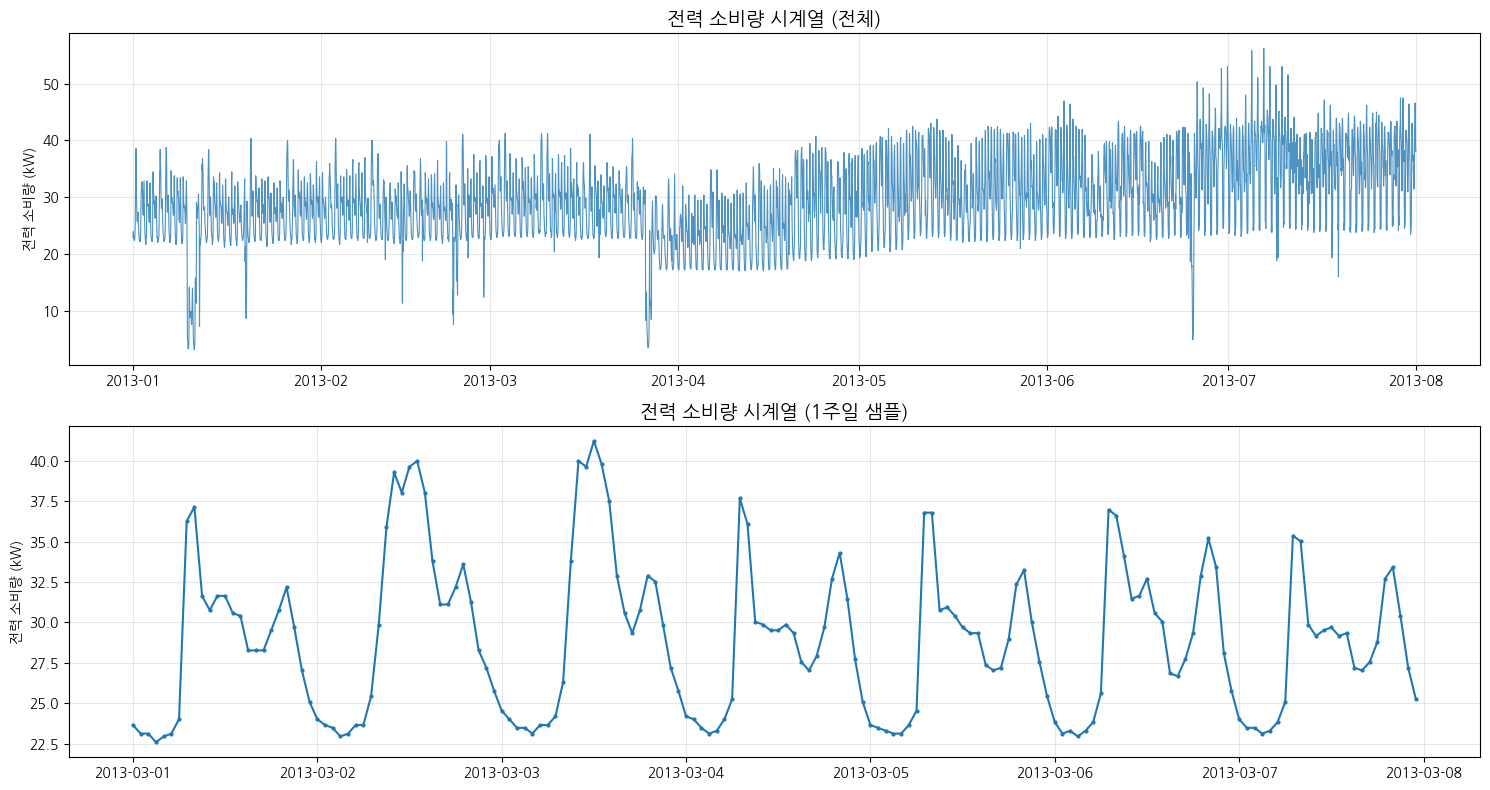


기본 통계:
count    5088.000000
mean       29.333482
std         7.131563
min         3.200569
25%        23.826458
50%        28.805121
75%        33.961593
max        56.187767
Name: power_usage, dtype: float64


In [14]:
# 전체 시계열 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# 전체 데이터
axes[0].plot(df['power_usage'], linewidth=0.8, alpha=0.8)
axes[0].set_title('전력 소비량 시계열 (전체)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('전력 소비량 (kW)')
axes[0].grid(True, alpha=0.3)

# 일주일 샘플
week_sample = df['power_usage']['2013-03-01':'2013-03-07']
axes[1].plot(week_sample, linewidth=1.5, marker='o', markersize=2)
axes[1].set_title('전력 소비량 시계열 (1주일 샘플)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('전력 소비량 (kW)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n기본 통계:")
print(df['power_usage'].describe())

### 1.3.1 시간대별/요일별 패턴 분석

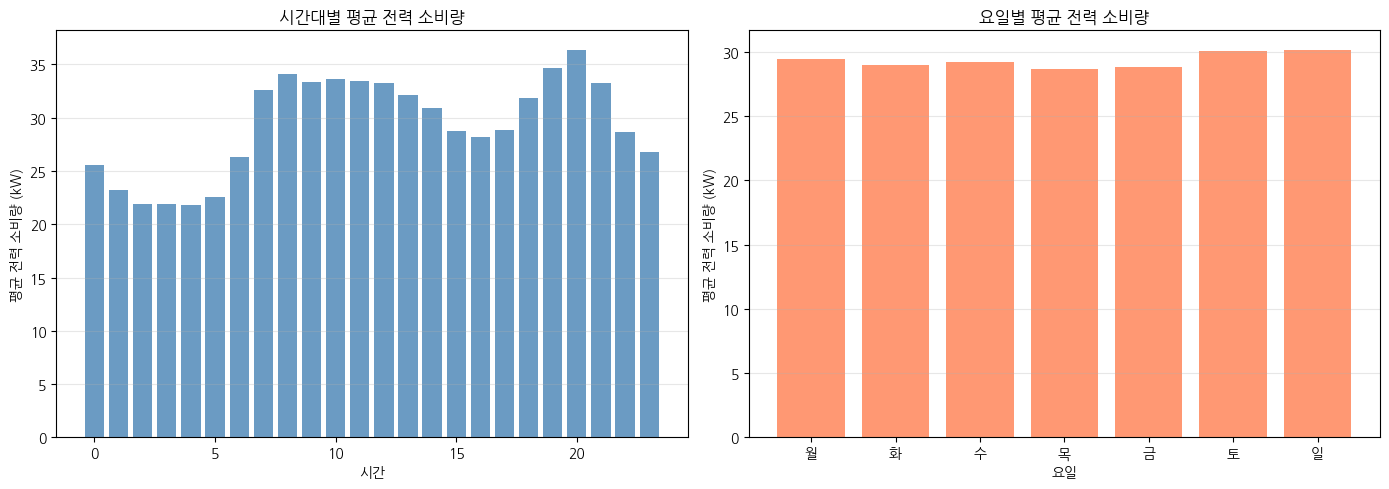

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 시간대별 평균
hourly_avg = df.groupby('hour')['power_usage'].mean()
axes[0].bar(hourly_avg.index, hourly_avg.values, color='steelblue', alpha=0.8)
axes[0].set_title('시간대별 평균 전력 소비량', fontsize=12, fontweight='bold')
axes[0].set_xlabel('시간')
axes[0].set_ylabel('평균 전력 소비량 (kW)')
axes[0].grid(True, alpha=0.3, axis='y')

# 요일별 평균
daily_avg = df.groupby('day_of_week')['power_usage'].mean()
day_names = ['월', '화', '수', '목', '금', '토', '일']
axes[1].bar(range(7), daily_avg.values, color='coral', alpha=0.8)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names)
axes[1].set_title('요일별 평균 전력 소비량', fontsize=12, fontweight='bold')
axes[1].set_xlabel('요일')
axes[1].set_ylabel('평균 전력 소비량 (kW)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

주로 아침과 저녁시간대에 평균 전력 소비가 높은 것을 확인할 수 있습니다!

---

# Part 2. 정상성 검정 및 차분

## 2.1 정상성 검정 함수 정의

**정상성 검정 방법:**
1. **ADF 검정 (Augmented Dickey-Fuller Test)**
   - 귀무가설(H0): 시계열이 비정상(단위근 존재)
   - p-value < 0.05 → 귀무가설 기각 → **정상 시계열** ✅
   
2. **KPSS 검정 (Kwiatkowski-Phillips-Schmidt-Shin Test)**
   - 귀무가설(H0): 시계열이 정상
   - p-value > 0.05 → 귀무가설 채택 → **정상 시계열** ✅

In [30]:
def adf_test(series, name=''):
    """ADF 검정 (귀무가설: 비정상)"""
    # 힌트: adfuller(시계열데이터)
    result = adfuller(series.dropna())
    print(f"{'='*50}")
    print(f"ADF Test: {name}")
    print(f"{'='*50}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    # 힌트: p-value < 0.05이면 정상
    print(f"결과: {'✅ 정상 시계열' if result[1] < 0.05 else '❌ 비정상 시계열'}")
    return result[1] < 0.05

def kpss_test(series, name=''):
    """KPSS 검정 (귀무가설: 정상)"""
    # 힌트: kpss(시계열데이터, regression='c')
    result = kpss(series.dropna(), regression='c')
    print(f"{'='*50}")
    print(f"KPSS Test: {name}")
    print(f"{'='*50}")
    print(f"KPSS Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    # 힌트: p-value > 0.05이면 정상
    print(f"결과: {'✅ 정상 시계열' if result[1] > 0.05 else '❌ 비정상 시계열'}")
    return result[1] > 0.05

## 2.2 원본 데이터 정상성 검정

In [32]:
print("\n[원본 데이터 정상성 검정]\n")
adf_original = adf_test(df['power_usage'], '원본 데이터')
print()
kpss_original = kpss_test(df['power_usage'], '원본 데이터')


[원본 데이터 정상성 검정]

ADF Test: 원본 데이터
ADF Statistic: -4.8850
p-value: 0.0000
결과: ✅ 정상 시계열

KPSS Test: 원본 데이터
KPSS Statistic: 8.1417
p-value: 0.0100
결과: ❌ 비정상 시계열


/tmp/ipython-input-2103231576.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


## 2.3 ACF/PACF 분석

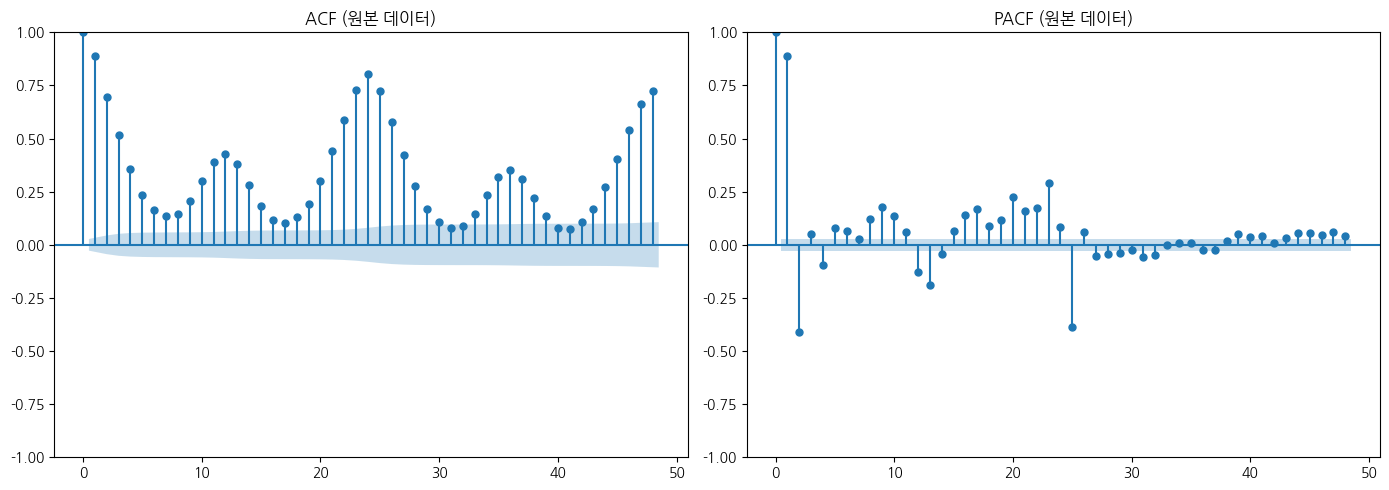

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df['power_usage'].dropna(), ax=axes[0], lags=48)  # 48시간 = 2일
axes[0].set_title('ACF (원본 데이터)', fontsize=12, fontweight='bold')

plot_pacf(df['power_usage'].dropna(), ax=axes[1], lags=48)
axes[1].set_title('PACF (원본 데이터)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

lags=48을 주면

lag 1: 현재 데이터 vs 1시간 뒤 데이터  
lag 2: 현재 데이터 vs 2시간 뒤 데이터  
lag 3: 현재 데이터 vs 3시간 뒤 데이터  
…  
lag 48: 현재 데이터 vs 48시간 뒤(=2일 뒤) 데이터  
즉, lag 1부터 lag 48까지 각각의 상관 계수를 모두 구해서 그래프에 그린 것입니다.  
ACF: 24시간마다 반복되는 피크가 관찰됩니다. → 계절 비정상성(Seasonal Non-Stationarity)이 보입니다.  
PCAF: 전체적으로 불규칙한 상승, 하강 패턴을 보입니다. -> 비정상성이 존재합니다.  

## 2.4 차분을 통한 정상성 확보

**차분 종류:**
1. **1차 차분**: 추세(trend) 제거
   - `diff()`: 현재 값에서 이전 값을 뺌
   
2. **계절 차분**: 계절성(seasonality) 제거
   - `diff(24)`: 24시간 전 값과의 차이 (일일 패턴 제거)
   
3. **1차 + 계절 차분**: 추세와 계절성 모두 제거
   - `diff().diff(24)`: 1차 차분 후 계절 차분 수행

**차분 후 정상성 검정을 통해 어떤 차분이 효과적인지 확인합니다.**

In [34]:
# 1차 차분
# 힌트: 데이터프레임['열'].diff()
df['power_diff'] = df['power_usage'].diff()

# 계절 차분 (24시간 주기)
# 힌트: 데이터프레임['열'].diff(주기)
df['power_diff_seasonal'] = df['power_usage'].diff(24)

# 1차 + 계절 차분
# 힌트: 데이터프레임['열'].diff().diff(주기)
df['power_diff_both'] = df['power_usage'].diff().diff(24)

print("\n[1차 차분 후 정상성 검정]\n")
adf_diff = adf_test(df['power_diff'], '1차 차분')
print()
kpss_diff = kpss_test(df['power_diff'], '1차 차분')

print("\n[계절 차분 (24시간 주기)]\n")
adf_diff_seasonal = adf_test(df['power_diff_seasonal'], '계절 차분')
print()
kpss_diff_seasonal = kpss_test(df['power_diff_seasonal'], '계절 차분')

print("\n[1차 + 계절 차분]\n")
adf_diff_both = adf_test(df['power_diff_both'], '1차+계절 차분')
print()
kpss_diff_both = kpss_test(df['power_diff_both'], '1차+계절 차분')


[1차 차분 후 정상성 검정]

ADF Test: 1차 차분
ADF Statistic: -15.4467
p-value: 0.0000
결과: ✅ 정상 시계열



/tmp/ipython-input-2103231576.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


KPSS Test: 1차 차분
KPSS Statistic: 0.0184
p-value: 0.1000
결과: ✅ 정상 시계열

[계절 차분 (24시간 주기)]

ADF Test: 계절 차분
ADF Statistic: -13.8572
p-value: 0.0000
결과: ✅ 정상 시계열

KPSS Test: 계절 차분
KPSS Statistic: 0.0112
p-value: 0.1000
결과: ✅ 정상 시계열

[1차 + 계절 차분]



/tmp/ipython-input-2103231576.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


ADF Test: 1차+계절 차분
ADF Statistic: -20.2063
p-value: 0.0000
결과: ✅ 정상 시계열

KPSS Test: 1차+계절 차분
KPSS Statistic: 0.0260
p-value: 0.1000
결과: ✅ 정상 시계열


/tmp/ipython-input-2103231576.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


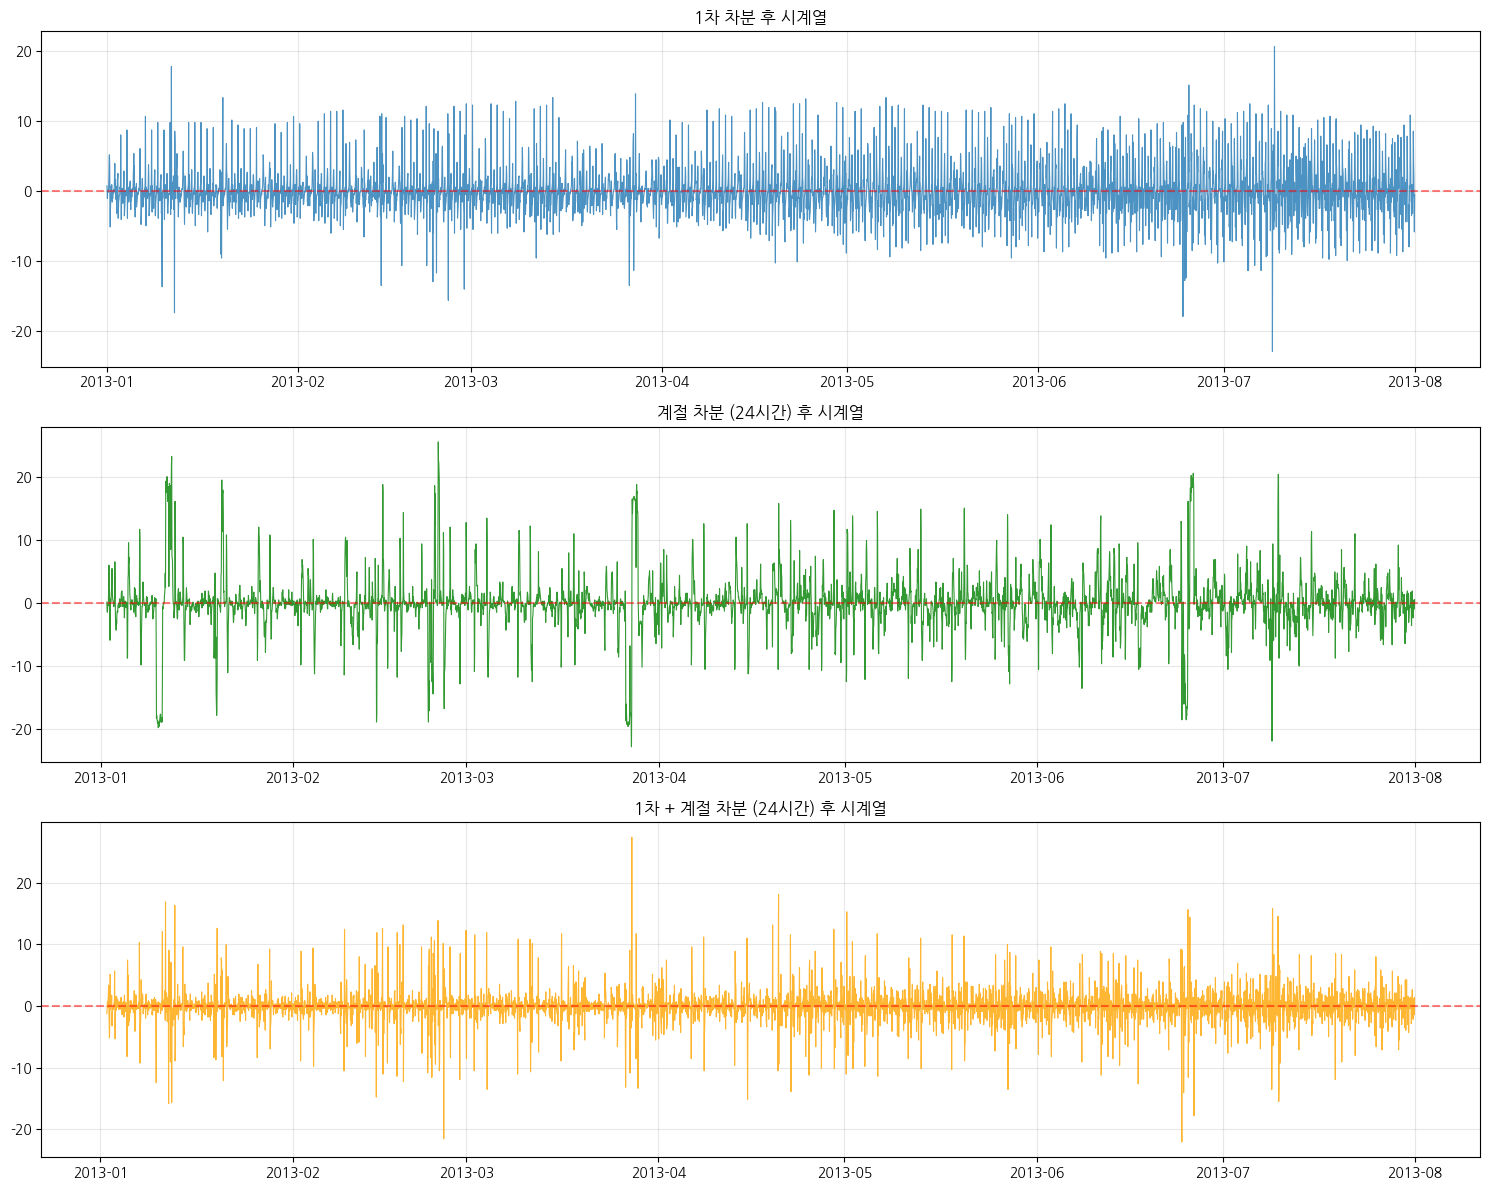

In [35]:
# 차분 후 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

axes[0].plot(df['power_diff'].dropna(), linewidth=0.8, alpha=0.8)
axes[0].set_title('1차 차분 후 시계열', fontsize=12, fontweight='bold')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['power_diff_seasonal'].dropna(), linewidth=0.8, alpha=0.8, color='green')
axes[1].set_title('계절 차분 (24시간) 후 시계열', fontsize=12, fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['power_diff_both'].dropna(), linewidth=0.8, alpha=0.8, color='orange')
axes[2].set_title('1차 + 계절 차분 (24시간) 후 시계열', fontsize=12, fontweight='bold')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# Part 3. Train/Test 분할 및 평가 함수

Train 크기: 4070 (169일)
Test 크기: 1018 (42일)
Train 기간: 2013-01-01 00:00:00 ~ 2013-06-19 13:00:00
Test 기간: 2013-06-19 14:00:00 ~ 2013-07-31 23:00:00


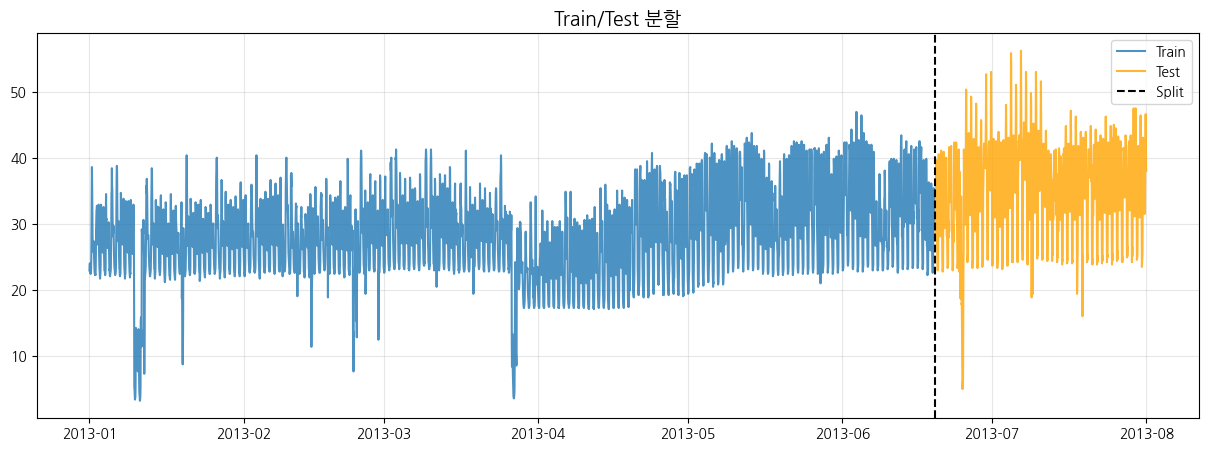

In [36]:
# Train/Test 분할 (80:20)
train_size = int(len(df) * 0.8)
train = df['power_usage'].iloc[:train_size]
test = df['power_usage'].iloc[train_size:]

print(f"Train 크기: {len(train)} ({len(train)//24}일)")
print(f"Test 크기: {len(test)} ({len(test)//24}일)")
print(f"Train 기간: {train.index.min()} ~ {train.index.max()}")
print(f"Test 기간: {test.index.min()} ~ {test.index.max()}")

# 시각화
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.values, label='Train', alpha=0.8)
plt.plot(test.index, test.values, label='Test', alpha=0.8, color='orange')
plt.axvline(x=train.index[-1], color='black', linestyle='--', label='Split')
plt.title('Train/Test 분할', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
def evaluate_model(actual, predicted, model_name):
    """모델 평가 함수"""
    # NaN 제거
    mask = ~(pd.isna(actual) | pd.isna(predicted))
    actual = np.array(actual)[mask]
    predicted = np.array(predicted)[mask]

    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100

    print(f"\n{'='*50}")
    print(f"모델: {model_name}")
    print(f"{'='*50}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# 결과 저장용 리스트
results = []

---

# Part 4. 전통 통계 모델

## 4.1 ARIMA 모델

우선 계절성을 고려하지 않고 정상성만 만족시킨 후 ARIMA 모델을 적용해봅시다.

### 어떤 차수가 적합할까요?
차분 후 ACF, PACF로 ARIMA 모델의 적절한 차수를 찾습니다.

|  | **ACF 그래프** 모습 | **PACF 그래프** 모습 |
| --- | --- | --- |
| **AR(p) 사용**해야 할 때 | 천천히 감소 or 진동 감소 | p+1 시점부터 0에 근접 |
| **MA(q) 사용**해야 할 때 | q+1 시점부터 0에 근접 | 천천히 감소 or 진동 감소 |
| **ARMA(p, q) 사용**해야 할 때 | q+1 시점부터 0에 근접 | p+1 시점부터 0에 근접 |

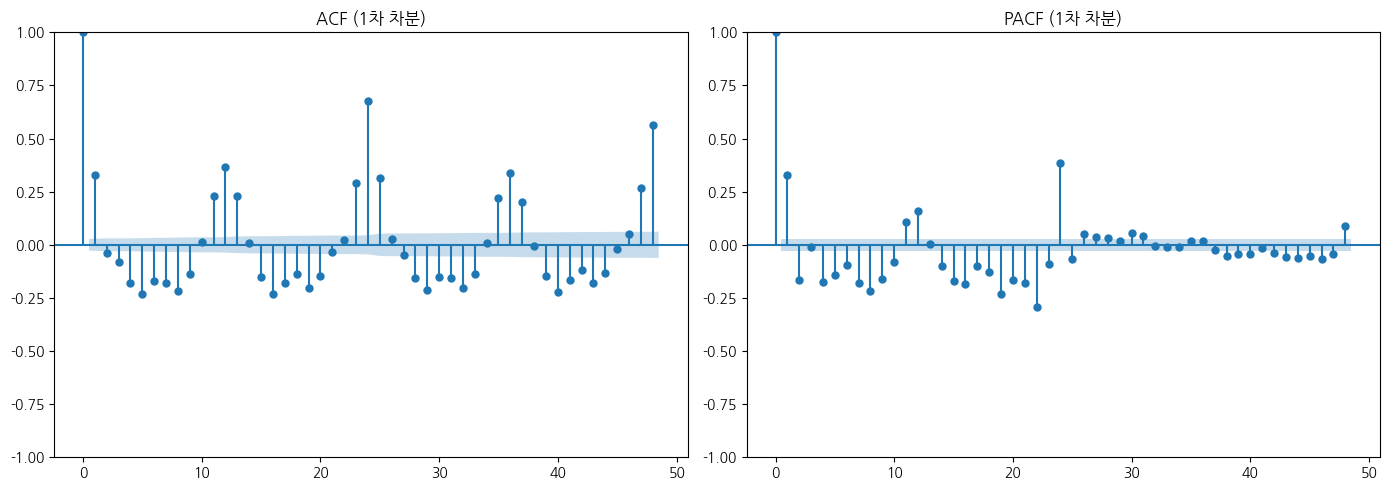

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1차 차분 데이터
diff_data = df['power_diff'].dropna()

# ACF 플롯
# 힌트: plot_acf(데이터, ax=축, lags=시차수(위를 참고하세요))
plot_acf(diff_data, ax=axes[0], lags=48)
axes[0].set_title('ACF (1차 차분)', fontsize=12, fontweight='bold')

# PACF 플롯
# 힌트: plot_pacf(데이터, ax=축, lags=시차수)
plot_pacf(diff_data, ax=axes[1], lags=48)
axes[1].set_title('PACF (1차 차분)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

그래프 해석  
- ACF: 진동 감소 -> 여전히 여러 시차의 과거 값과 약하게 연결되어 있습니다.  
- PACF: lag 1~24까지는 일부 진폭 있음, 하지만 25부터 거의 0 -> 이건 하루 주기(계절성)의 영향입니다!  
-> ARIMA는 계절성을 직접 모델링하지 않기 때문에 이 데이터에서 적합한 모델이 아닙니다.  
  
따라서 "PACF의 lag 25부터 0으로 떨어진다"고 하더라도 p = 24로 설정하는 것이 정답이 아니에요.   
(p가 커지면 불필요한 학습 파라미터가 늘어나며 과적합 위험이 있음)  
일단 적합하지 않은 모델이니깐 (p,d,q)를 임의로 (2,1,1)로 설정하고 돌려보겠습니다!

In [39]:
# ARIMA 모델 생성
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 파라미터 설정
# 원본 데이터에 대해 Train, Test를 나눴으니 정상화된 시계열 데이터에 대해 모델을 적용해야 합니다.
# 차분 필요!
arima_order = (2, 1, 1)  # (p, d, q)

# 모델 생성
#힌트: ARIMA(학습데이터, order=파라미터)
arima_model = ARIMA(train, order=arima_order)
print(f"✅ ARIMA{arima_order} 모델 생성 완료")
print(f"   - p (AR order): {arima_order[0]} - 과거 p개 시점의 값 사용")
print(f"   - d (차분 횟수): {arima_order[1]} - 정상성 확보")
print(f"   - q (MA order): {arima_order[2]} - 과거 q개 오차항 사용")

✅ ARIMA(2, 1, 1) 모델 생성 완료
   - p (AR order): 2 - 과거 p개 시점의 값 사용
   - d (차분 횟수): 1 - 정상성 확보
   - q (MA order): 1 - 과거 q개 오차항 사용


In [40]:
# ARIMA 모델 학습
print("ARIMA 모델 학습 중...")
arima_fit = arima_model.fit()
print("✅ ARIMA 학습 완료!")

# 모델 요약
print("\n[모델 요약]")
print(arima_fit.summary())

ARIMA 모델 학습 중...
✅ ARIMA 학습 완료!

[모델 요약]
                               SARIMAX Results                                
Dep. Variable:            power_usage   No. Observations:                 4070
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9842.401
Date:                Thu, 27 Nov 2025   AIC                          19692.801
Time:                        10:58:48   BIC                          19718.046
Sample:                    01-01-2013   HQIC                         19701.742
                         - 06-19-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2186      0.011    110.891      0.000       1.197       1.240
ar.L2         -0.4467      0.010    -44.880      0.000      -0.466      -0.427
ma.L1      

### 3.4 ARIMA 예측 및 평가

**예측 수행:**
- `forecast(steps=n)`: 학습된 모델로 n개 시점을 예측합니다.
- 예측 결과의 인덱스를 테스트 데이터의 인덱스와 맞춰줍니다.

**평가:**
- 예측값과 실제값을 비교하여 모델 성능을 평가합니다.
- 평가 결과는 나중에 다른 모델들과 비교하기 위해 저장합니다.

In [41]:
# ARIMA 예측 및 평가
arima_pred = arima_fit.forecast(steps=len(test))
arima_pred.index = test.index

# 평가
result = evaluate_model(test, arima_pred, f'ARIMA{arima_order}')
results.append(result)


모델: ARIMA(2, 1, 1)
RMSE: 8.3878
MAE:  7.1739
MAPE: 21.68%


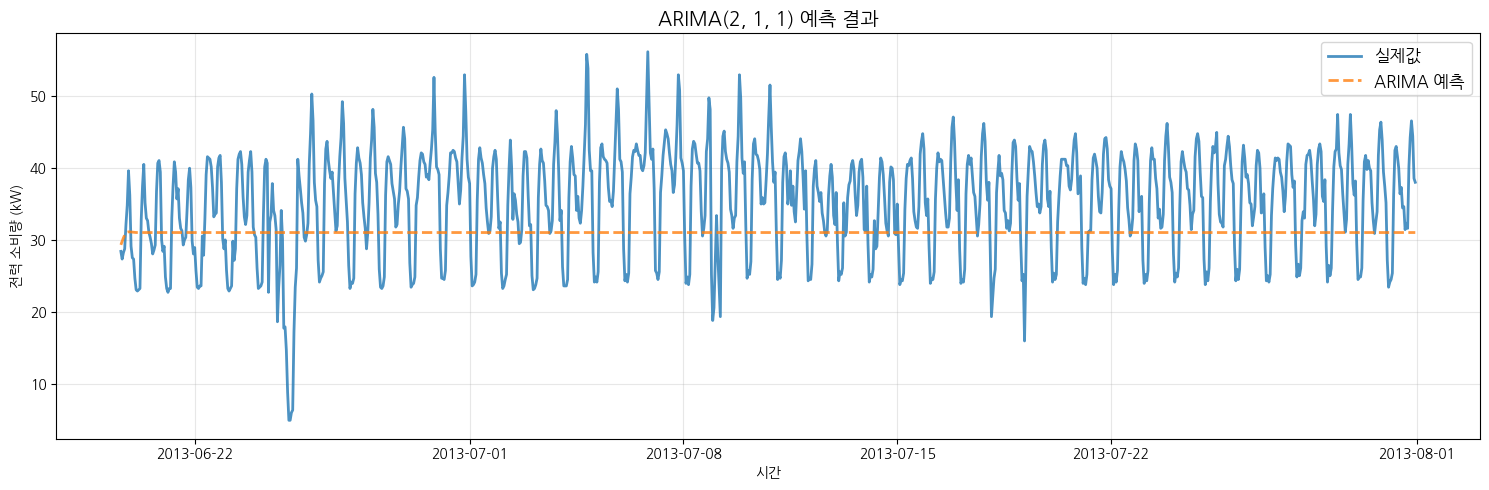

In [42]:
# ARIMA 예측 시각화
plt.figure(figsize=(15, 5))
plt.plot(test.index, test.values, label='실제값', alpha=0.8, linewidth=2)
plt.plot(test.index, arima_pred.values, label='ARIMA 예측', linestyle='--', alpha=0.8, linewidth=2)
plt.title(f'ARIMA{arima_order} 예측 결과', fontsize=14, fontweight='bold')
plt.xlabel('시간')
plt.ylabel('전력 소비량 (kW)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### ARIMA 결과 해석

**모델 특성:**
- ARIMA(2,1,2)는 2차 자기회귀(AR) + 1차 차분 + 1차 이동평균(MA) 구조입니다.
- 정상성을 위해 1차 차분을 적용했습니다 (d=1).

**예측 결과 분석:**
- ARIMA는 **계절성(일별/주별 패턴)을 명시적으로 반영하지 못합니다**.
- 따라서 예측 결과가 정말 형편없게 나왔습니다.

**개선 방향:**
- 계절 차분한 데이터(계절성 제거)로 ARIMA 적용하기
- 계절성 반영을 위해 SARIMA 사용 권장
- 외생변수(날씨, 요일 등) 추가 시 ARIMAX 고려

### 참고) ARIMA 파라미터 조정 가이드

| 파라미터 | 효과 |
|---------|------|
| **p (AR)** | 값이 클수록 과거 의존성 ↑, 과적합 위험 ↑ |
| **d (차분)** | ADF 검정 결과에 따라 결정, 보통 1~2 |
| **q (MA)** | 값이 클수록 노이즈 평활화 ↑ |

**파라미터 선택 팁:**
1. **ACF/PACF 분석**: PACF에서 절단되는 lag → p, ACF에서 절단되는 lag → q
2. **정보 기준**: AIC, BIC가 낮은 조합 선택
3. **Grid Search**: 여러 조합 시도 후 최적 선택

```python
# 파라미터 튜닝 예시
from itertools import product

best_aic = float('inf')
best_order = None

for p, d, q in product(range(4), range(2), range(4)):
    try:
        model = ARIMA(train, order=(p,d,q)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = (p,d,q)
    except:
        continue

print(f"최적 파라미터: {best_order}, AIC: {best_aic}")
```

## 4.2 SARIMA

SARIMA 모델도 정상화된 시계열에 대해 적용해야 합니다.  
1차 차분 + 계절 차분한 데이터에서(비정상성 만족) ACF/PACF 확인하여 적절한 차수를 결정해봐요.

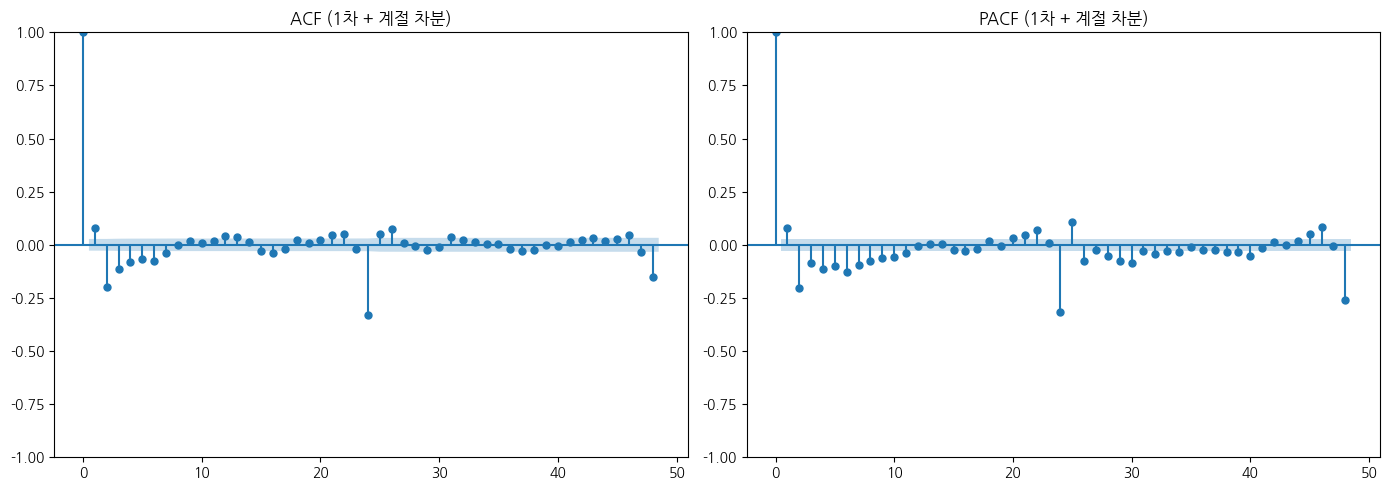

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 계절성 제거: 1차 차분 + 24시간 계절 차분 ---
seasonal_diff = df['power_diff_both'].dropna() # 재거하려면 어떻게 했어야 했죠?

# ACF
plot_acf(seasonal_diff, ax=axes[0], lags=48)
axes[0].set_title('ACF (1차 + 계절 차분)', fontsize=12, fontweight='bold')

# PACF
plot_pacf(seasonal_diff, ax=axes[1], lags=48, method='ywm')
axes[1].set_title('PACF (1차 + 계절 차분)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

그래프 해석  
ACF: lag0 → lag1,2에서 급격히 감소, lag25에서 다시 spike 발생 → 이후 비슷한 패턴 반복  
PACF: lag0 → lag1,2에서 급격히 감소, lag25에서 다시 spike 발생 → 이후 비슷한 패턴 반복  
lag25에서 spike가 약간의 spike가 발생하는데 이는 계절 차분 후에도 약간의 계절성이 남아 있기 때문입니다.  
이는 완전한 정상성을 만족한다고 할 순 없지만 약정상성을 만족한다고 할 수 있고  
SARIMA 모델에서 P/Q 차수로 어느정도 흡수가 가능합니다!

적절한 파라미터  
 SARIMA(p,d,q)(P,D,Q,s)

| 파라미터 |  차수    |
| -- | ------- |
| d  | 비계절 차분 d = 1  |
| D  | 계절 차분 D = 1  |
| s  | s = 24  |
| p  | p = 1~2 |
| q  | q = 1~2 |
| P  | P = 1   |
| Q  | Q = 1   |


In [44]:
# SARIMA 모델 생성
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 적절한 SARIMA 파라미터 설정
sarima_order = (2, 1, 2)           # (p, d, q) = (2, 1, 2)
sarima_seasonal = (1, 1, 1, 24)    # (P, D, Q, s) - 24시간 주기 =  (1, 1, 1, 24)

print("SARIMA 모델 파라미터:")
print(f"  비계절: order={sarima_order}")
print(f"  계절:   seasonal_order={sarima_seasonal}")
print(f"  계절 주기: 24시간 (일일 패턴)")

SARIMA 모델 파라미터:
  비계절: order=(2, 1, 2)
  계절:   seasonal_order=(1, 1, 1, 24)
  계절 주기: 24시간 (일일 패턴)


In [45]:
# SARIMA 모델 학습
print("\nSARIMA 모델 학습 중... (시간이 걸릴 수 있습니다)")

sarima_model = SARIMAX(
    train,
    order=sarima_order,
    seasonal_order=sarima_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False, maxiter=200)
print("✅ SARIMA 학습 완료!")


SARIMA 모델 학습 중... (시간이 걸릴 수 있습니다)
✅ SARIMA 학습 완료!


In [46]:
# SARIMA 예측 및 평가
sarima_pred = sarima_fit.forecast(steps=len(test))
sarima_pred.index = test.index

# 평가
result = evaluate_model(test, sarima_pred, f'SARIMA{sarima_order}x{sarima_seasonal}')
results.append(result)


모델: SARIMA(2, 1, 2)x(1, 1, 1, 24)
RMSE: 8.4879
MAE:  7.6743
MAPE: 22.30%


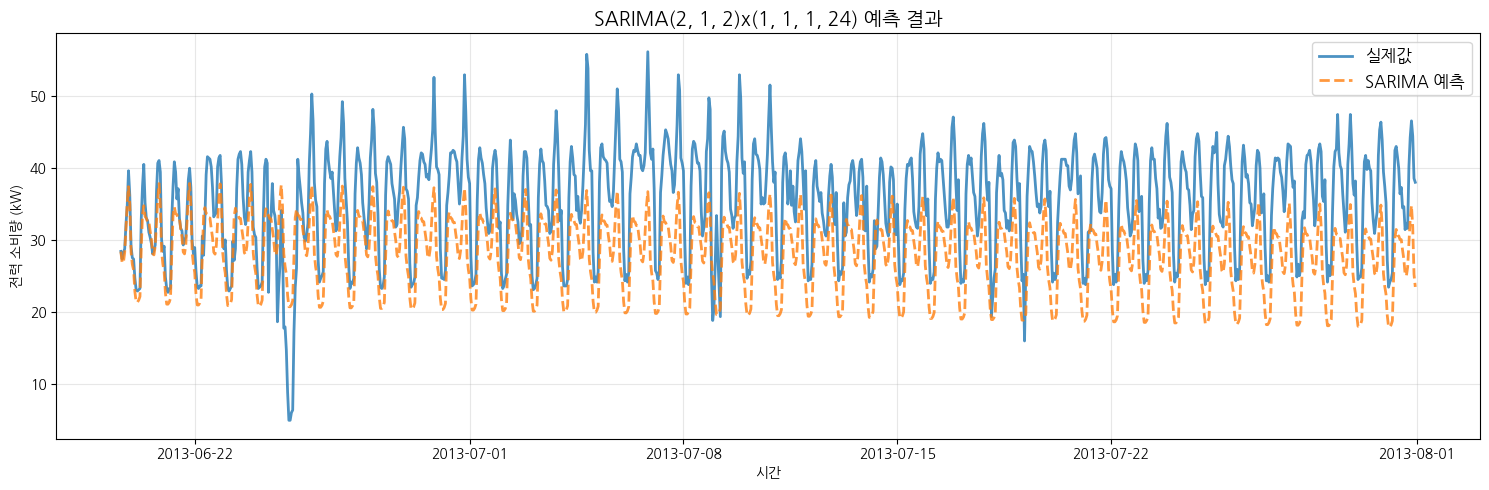

In [47]:
# SARIMA 예측 시각화
plt.figure(figsize=(15, 5))
plt.plot(test.index, test.values, label='실제값', alpha=0.8, linewidth=2)
plt.plot(test.index, sarima_pred.values, label='SARIMA 예측', linestyle='--', alpha=0.8, linewidth=2)
plt.title(f'SARIMA{sarima_order}x{sarima_seasonal} 예측 결과', fontsize=14, fontweight='bold')
plt.xlabel('시간')
plt.ylabel('전력 소비량 (kW)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### SARIMA 결과 해석

**모델 특성:**
- SARIMA(p,d,q)×(1,1,1,24)는 **24시간 계절성**을 명시적으로 반영합니다.
- 전력 소비의 일일 패턴(아침 피크, 저녁 피크)을 학습합니다.

**예측 결과 분석:**
- ARIMA 대비 **계절적 패턴 예측 성능이 개선**됩니다.
- 일정한 주기를 가진 시계열에서 강점을 발휘합니다.
- 계절 주기(s=24)가 데이터 특성에 잘 맞아야 효과적입니다.

**주의사항:**
- 계산 비용이 높음 (큰 데이터셋에서 학습 시간 증가)
- 계절 파라미터(P, D, Q, s) 튜닝이 중요

### SARIMA 파라미터 조정 가이드

**성능 향상 팁:**
1. **계절 주기 선택**: 전력 데이터는 s=24(일별) 또는 s=168(주별) 고려
2. **파라미터 단순화**: (P,D,Q)는 (1,1,1) 또는 (0,1,1)로 시작
3. **RandomizedSearch**
4. **AIC/BIC 기준**: 정보 기준이 낮은 모델 선택

```python
# 계절 주기별 비교 예시
for s in [24, 168]:  # 일별, 주별
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,s))
    fit = model.fit(disp=False)
    print(f"s={s}: AIC={fit.aic:.2f}")

# RandomizedSearch 예시
# seasonal=True, m=24 -> 일별 계절성
model = auto_arima(
    y,
    start_p=0, max_p=3,      # AR 범위
    start_q=0, max_q=3,      # MA 범위
    d=1,                     # 비계절 차분
    start_P=0, max_P=2,      # 계절 AR 범위
    start_Q=0, max_Q=2,      # 계절 MA 범위
    D=1,                     # 계절 차분
    m=24,                    # 계절 주기 (24시간)
    seasonal=True,
    stepwise=False,           # 모든 조합 탐색 -> RandomizedSearch 느낌
    n_jobs=-1,                # 병렬 처리
    information_criterion='aic',  # AIC 기준 선택
    trace=True                # 탐색 과정 출력
)

print("\nBest SARIMA model summary:")
print(model.summary())

```

## 4.3 Holt-Winters (지수평활법)

**Holt-Winters (Triple Exponential Smoothing):**
- 수준(Level), 추세(Trend), 계절성(Seasonality)을 모두 고려하는 지수평활법

**주요 파라미터:**
- `seasonal`: 계절성 유형
  - `'add'`: 가법 모델 (계절 변동폭이 일정)
  - `'mul'`: 승법 모델 (계절 변동폭이 증가/감소)
- `seasonal_periods`: 계절 주기 (예: 24시간)
- `trend`: 추세 유형 (`'add'`, `'mul'`, `None`)
- `damped_trend`: 추세 감쇠 적용 여부 (장기 예측 시 추세가 과도하게 증가하는 것을 방지)

**최적화:**
- `fit(optimized=True)`: 모델 파라미터를 자동으로 최적화

In [48]:
# Holt-Winters 모델 생성
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 파라미터 설정
seasonal_periods = 24  # 24시간 주기

print("Holt-Winters 모델 파라미터:")
print(f"  계절 주기: {seasonal_periods}시간")
print(f"  계절 유형: additive (가법)")
print(f"  추세 유형: additive (가법)")

Holt-Winters 모델 파라미터:
  계절 주기: 24시간
  계절 유형: additive (가법)
  추세 유형: additive (가법)


In [50]:
# Holt-Winters 모델 학습
print("\nHolt-Winters 모델 학습 중...")

# 힌트: ExponentialSmoothing(데이터, seasonal='타입', seasonal_periods=주기, trend='타입', damped_trend=True/False)
hw_model = ExponentialSmoothing(
    train,
    seasonal='add',
    seasonal_periods=seasonal_periods,
    trend='add',
    damped_trend=True  # 추세 감쇠 적용
)
# 힌트: 모델객체.fit(optimized=True)
hw_fit = hw_model.fit(optimized=True)
print("✅ Holt-Winters 학습 완료!")


Holt-Winters 모델 학습 중...
✅ Holt-Winters 학습 완료!


In [52]:
# Holt-Winters 예측 및 평가
hw_pred = hw_fit.forecast(steps=len(test))
hw_pred.index = test.index

# 평가
result = evaluate_model(test, hw_pred, 'Holt-Winters')
results.append(result)


모델: Holt-Winters
RMSE: 9.4303
MAE:  8.4768
MAPE: 24.15%


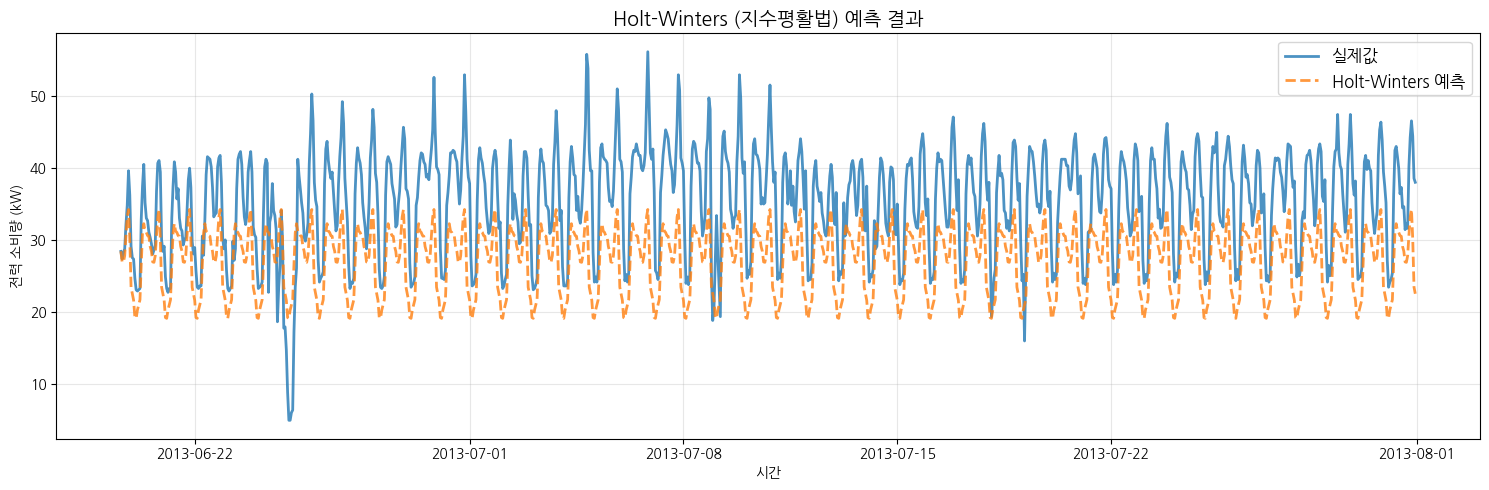

In [53]:
# Holt-Winters 예측 시각화
plt.figure(figsize=(15, 5))
plt.plot(test.index, test.values, label='실제값', alpha=0.8, linewidth=2)
plt.plot(test.index, hw_pred.values, label='Holt-Winters 예측', linestyle='--', alpha=0.8, linewidth=2)
plt.title('Holt-Winters (지수평활법) 예측 결과', fontsize=14, fontweight='bold')
plt.xlabel('시간')
plt.ylabel('전력 소비량 (kW)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Holt-Winters 결과 해석

**모델 특성:**
- **Triple Exponential Smoothing**: Level + Trend + Seasonality 3가지 요소를 평활화
- 최근 관측값에 더 큰 가중치를 부여하여 빠른 적응력 확보
- damped_trend=True로 장기 추세의 과도한 외삽 방지

**예측 결과 분석:**
- 계절성 패턴을 잘 포착하여 **일일 변동 예측에 강점**
- SARIMA보다 **계산 속도가 빠름**
- 급격한 구조적 변화에는 적응이 느릴 수 있음

**적합한 상황:**
- 명확한 추세와 계절성이 있는 데이터
- 실시간 예측이 필요한 경우 (빠른 학습)

### Holt-Winters 파라미터 조정 가이드

| 파라미터 | 현재값 | 옵션 | 설명 |
|---------|--------|------|------|
| **seasonal** | 'add' | 'add', 'mul' | 가법(덧셈)/승법(곱셈) 계절성 |
| **trend** | 'add' | 'add', 'mul', None | 추세 유형 |
| **damped_trend** | True | True, False | 추세 감쇠 여부 |
| **seasonal_periods** | 24 | 데이터 특성 | 계절 주기 |

**성능 향상 팁:**
1. **가법 vs 승법**: 변동폭이 시간에 따라 일정하면 가법, 비례적이면 승법
2. **추세 감쇠**: 장기 예측 시 damped_trend=True 권장
3. **계절 주기**: 데이터 패턴에 맞게 설정 (24=일별, 168=주별)

```python
# 가법/승법 비교
for seasonal_type in ['add', 'mul']:
    model = ExponentialSmoothing(
        train, seasonal=seasonal_type,
        seasonal_periods=24, trend='add'
    ).fit()
    pred = model.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, pred))
    print(f"{seasonal_type}: RMSE = {rmse:.2f}")
```

---

# Part 5. 딥러닝 모델 - LSTM

## 5.1 데이터 준비

In [55]:
# 스케일링
scaler = MinMaxScaler() # MinMaxScaler()를 사용합니다
data_scaled = scaler.fit_transform(df['power_usage'].values.reshape(-1, 1)) # 예측하고 즉시 적용하려면 어떻게 했어야 했죠?

# 시퀀스 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# 시퀀스 생성 (24시간 입력 -> 1시간 예측)
SEQ_LENGTH = 24
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Train/Test 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Tensor 변환
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test)

print(f"X_train shape: {X_train_t.shape}")
print(f"y_train shape: {y_train_t.shape}")
print(f"X_test shape: {X_test_t.shape}")
print(f"y_test shape: {y_test_t.shape}")

X_train shape: torch.Size([4051, 24, 1])
y_train shape: torch.Size([4051, 1])
X_test shape: torch.Size([1013, 24, 1])
y_test shape: torch.Size([1013, 1])


## 5.2 LSTM 모델 정의

In [59]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM
        lstm_out, _ = self.lstm(x)
        # 마지막 시점의 출력만 사용
        out = self.fc(lstm_out[:, -1, :])
        return out

# 모델 초기화
lstm_model = LSTMModel()
criterion = nn.MSELoss() # 손실 함수
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001) # 힌트: Adam 옵티마이저 사용

print(f"모델 파라미터 수: {sum(p.numel() for p in lstm_model.parameters()):,}")

모델 파라미터 수: 50,497


## 5.3 LSTM 학습

In [60]:
# 학습
EPOCHS = 50
BATCH_SIZE = 32

train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

loss_history = []

print("\nLSTM 모델 학습 시작...")
print("="*50)

for epoch in range(EPOCHS):
    lstm_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad() # 기울기 초기화
        output = lstm_model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] | Loss: {avg_loss:.6f}")

print("\n✅ LSTM 학습 완료!")


LSTM 모델 학습 시작...
Epoch [ 10/50] | Loss: 0.002977
Epoch [ 20/50] | Loss: 0.002773
Epoch [ 30/50] | Loss: 0.002233
Epoch [ 40/50] | Loss: 0.001765
Epoch [ 50/50] | Loss: 0.001549

✅ LSTM 학습 완료!


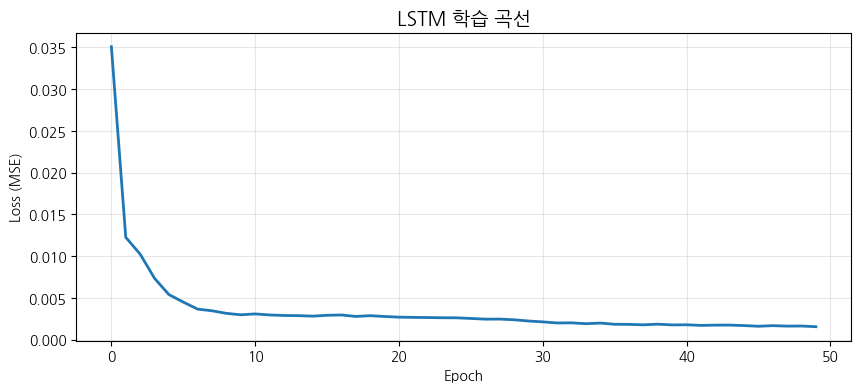

In [61]:
# 학습 곡선
plt.figure(figsize=(10, 4))
plt.plot(loss_history, linewidth=2)
plt.title('LSTM 학습 곡선', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True, alpha=0.3)
plt.show()

## 5.4 LSTM 예측 및 평가

In [62]:
# 예측
lstm_model.eval() # 평가 모드 전환
with torch.no_grad(): # 예측 시 기울기 계산 비활성화
    lstm_pred_scaled = lstm_model(X_test_t).numpy()

# 역변환
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()
lstm_actual = scaler.inverse_transform(y_test).flatten()

# 평가
result = evaluate_model(lstm_actual, lstm_pred, 'LSTM')
results.append(result)


모델: LSTM
RMSE: 3.7087
MAE:  2.8047
MAPE: 8.36%


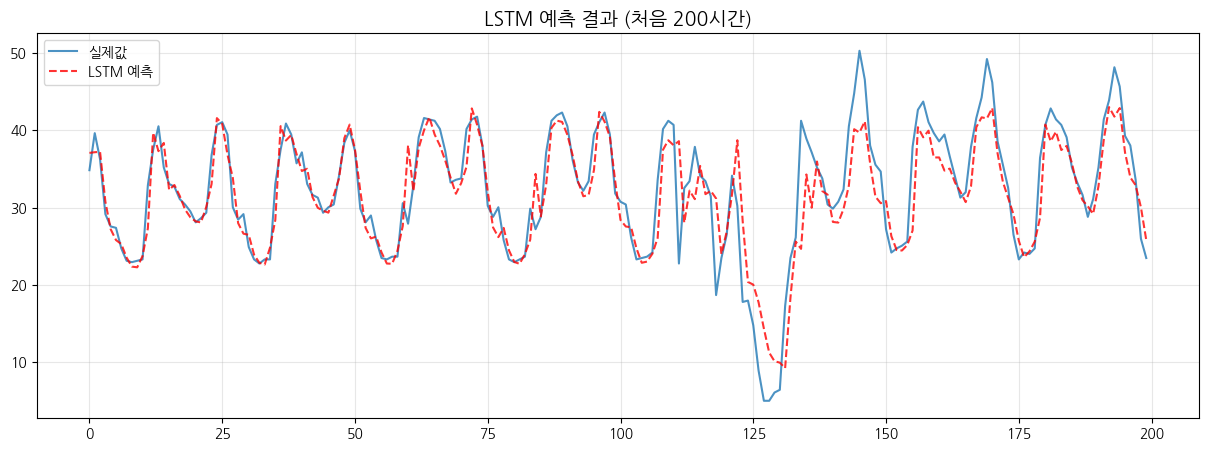

In [63]:
# LSTM 예측 시각화
plt.figure(figsize=(15, 5))
plt.plot(lstm_actual[:200], label='실제값', alpha=0.8)
plt.plot(lstm_pred[:200], label='LSTM 예측', linestyle='--', alpha=0.8, color='red')
plt.title('LSTM 예측 결과 (처음 200시간)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### LSTM 결과 해석

**모델 특성:**
- **Long Short-Term Memory**: 장기 의존성을 학습할 수 있는 순환 신경망
- Forget Gate, Input Gate, Output Gate를 통해 정보 흐름 제어
- 시계열의 복잡한 비선형 패턴 학습 가능

**예측 결과 분석:**
- 통계 모델 대비 **복잡한 패턴 포착 능력** 우수
- 충분한 학습 데이터가 있을 때 강력한 성능
- 과적합 위험이 있으므로 regularization 중요

**주의사항:**
- 학습 데이터 양에 민감
- 하이퍼파라미터 튜닝 필요
- 학습 시간이 오래 걸릴 수 있음

### LSTM 파라미터 조정 가이드

| 파라미터 | 현재값 | 조정 범위 | 효과 |
|---------|--------|----------|------|
| **hidden_size** | 64 | 32~256 | 클수록 표현력 ↑, 과적합 위험 ↑ |
| **num_layers** | 2 | 1~4 | 깊을수록 복잡한 패턴 학습, 학습 어려움 |
| **dropout** | 0.2 | 0.1~0.5 | 과적합 방지, 너무 높으면 학습 저하 |
| **learning_rate** | 0.001 | 1e-4~1e-2 | 학습 속도 조절 |
| **EPOCHS** | 50 | 30~200 | 충분히 학습하되 과적합 주의 |
| **seq_length** | 24 | 12~168 | 입력 시퀀스 길이 |

**성능 향상 팁:**
1. **학습률 스케줄링**: ReduceLROnPlateau 사용
2. **Early Stopping**: validation loss 모니터링
3. **Batch Normalization**: 학습 안정화
4. **Bidirectional LSTM**: 양방향 정보 활용

```python
# 개선된 LSTM 예시
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=0.3,
            bidirectional=True  # 양방향
        )
        self.bn = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 1)
```

---

# Part 5.5 Simple RNN 모델

LSTM의 간소화된 버전인 Simple RNN을 구현합니다.

In [64]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :])
        return out

# Simple RNN 모델 학습
rnn_model = SimpleRNN()
rnn_criterion = nn.MSELoss() # 손실 함수
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001) # Adam 옵티마이저 사용

print("Simple RNN 모델 학습 중...")
EPOCHS_RNN = 50

for epoch in range(EPOCHS_RNN):
    rnn_model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        rnn_optimizer.zero_grad()
        output = rnn_model(batch_X)
        loss = rnn_criterion(output, batch_y)
        loss.backward()
        rnn_optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS_RNN}] | Loss: {epoch_loss/len(train_loader):.6f}")

print("✅ Simple RNN 학습 완료!")

Simple RNN 모델 학습 중...
Epoch [ 10/50] | Loss: 0.002518
Epoch [ 20/50] | Loss: 0.002351
Epoch [ 30/50] | Loss: 0.002131
Epoch [ 40/50] | Loss: 0.001867
Epoch [ 50/50] | Loss: 0.001747
✅ Simple RNN 학습 완료!


In [65]:
# 예측
rnn_model.eval() # 평가 모드 전환
with torch.no_grad(): # 예측 시 기울기 계산 비활성화
    rnn_pred_scaled = rnn_model(X_test_t).numpy()

rnn_pred = scaler.inverse_transform(rnn_pred_scaled).flatten()
rnn_actual = scaler.inverse_transform(y_test).flatten()

# 평가
result = evaluate_model(rnn_actual, rnn_pred, 'Simple RNN')
results.append(result)


모델: Simple RNN
RMSE: 3.3651
MAE:  2.4376
MAPE: 7.13%


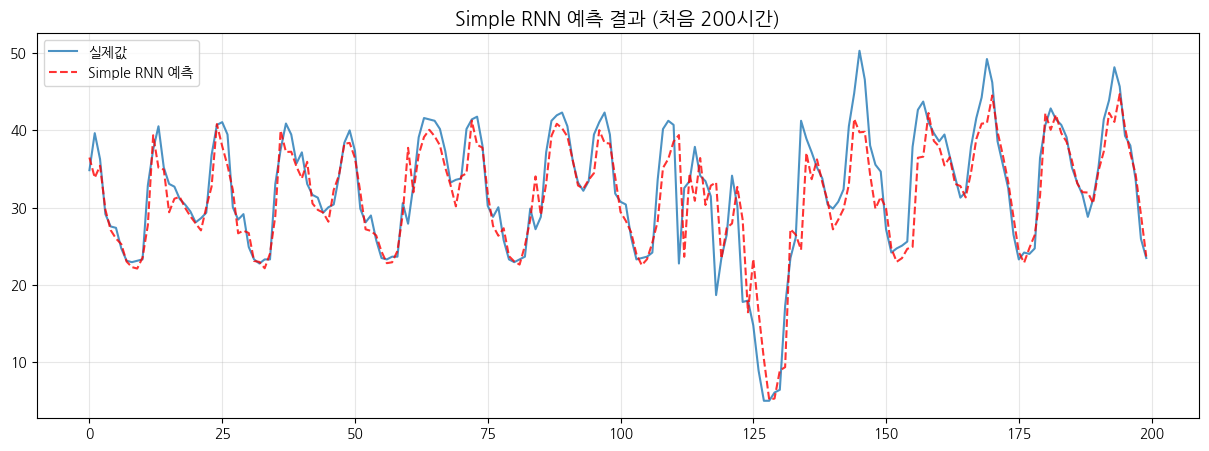

In [66]:
# Simple RNN 예측 시각화
plt.figure(figsize=(15, 5))
plt.plot(rnn_actual[:200], label='실제값', alpha=0.8)
plt.plot(rnn_pred[:200], label='Simple RNN 예측', linestyle='--', alpha=0.8, color='red')
plt.title('Simple RNN 예측 결과 (처음 200시간)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Simple RNN 결과 해석

**모델 특성:**
- **Vanilla RNN**: 가장 기본적인 순환 신경망 구조
- 이전 시점의 hidden state만 사용하여 현재 출력 계산
- 구조가 단순하여 학습이 빠름

**예측 결과 분석:**
- LSTM/GRU 대비 **단순한 패턴**만 학습 가능
- **장기 의존성 학습에 한계** (Vanishing Gradient 문제)
- 단기 패턴이나 단순한 시계열에 적합

**LSTM과의 비교:**
| 항목 | Simple RNN | LSTM |
|------|-----------|------|
| 장기 의존성 | 약함 | 강함 |
| 학습 속도 | 빠름 | 느림 |
| 파라미터 수 | 적음 | 많음 |
| 표현력 | 낮음 | 높음 |

### RNN 파라미터 조정 가이드

| 파라미터 | 현재값 | 권장 범위 | 설명 |
|---------|--------|----------|------|
| **hidden_size** | 64 | 32~128 | LSTM보다 작게 설정 권장 |
| **num_layers** | 2 | 1~2 | 깊으면 gradient vanishing 심화 |
| **nonlinearity** | 'tanh' | 'tanh', 'relu' | 활성화 함수 |

**Simple RNN 사용 권장 상황:**
- 데이터가 적을 때
- 단기 패턴만 중요할 때  
- 빠른 학습이 필요할 때
- 베이스라인 모델로 활용

---

# Part 5.6 GRU 모델

GRU(Gated Recurrent Unit)는 LSTM의 간소화된 변형으로, 더 적은 파라미터로 비슷한 성능을 낼 수 있습니다.

In [68]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# GRU 모델 학습
gru_model = GRUModel()
gru_criterion = nn.MSELoss() # 손실 함수
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001) # Adam 옵티마이저 사용

print("GRU 모델 학습 중...")

for epoch in range(EPOCHS):
    gru_model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        gru_optimizer.zero_grad()
        output = gru_model(batch_X)
        loss = gru_criterion(output, batch_y)
        loss.backward()
        gru_optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] | Loss: {epoch_loss/len(train_loader):.6f}")

print("✅ GRU 학습 완료!")

GRU 모델 학습 중...
Epoch [ 10/50] | Loss: 0.002921
Epoch [ 20/50] | Loss: 0.002126
Epoch [ 30/50] | Loss: 0.001979
Epoch [ 40/50] | Loss: 0.001821
Epoch [ 50/50] | Loss: 0.001621
✅ GRU 학습 완료!


In [69]:
# 예측
gru_model.eval() # 평가 모드 전환
with torch.no_grad(): # 예측 시 기울기 계산 비활성화
    gru_pred_scaled = gru_model(X_test_t).numpy()

gru_pred = scaler.inverse_transform(gru_pred_scaled).flatten()

# 평가
result = evaluate_model(lstm_actual, gru_pred, 'GRU')
results.append(result)


모델: GRU
RMSE: 2.9750
MAE:  2.1582
MAPE: 6.57%


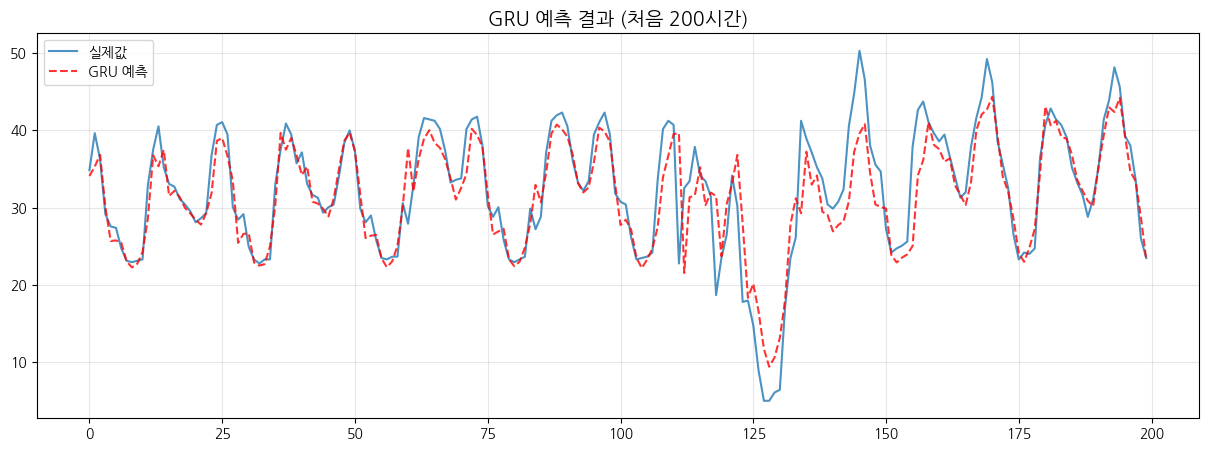

In [70]:
# GRU 예측 시각화
plt.figure(figsize=(15, 5))
plt.plot(lstm_actual[:200], label='실제값', alpha=0.8)
plt.plot(gru_pred[:200], label='GRU 예측', linestyle='--', alpha=0.8, color='red')
plt.title('GRU 예측 결과 (처음 200시간)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### GRU 결과 해석

**모델 특성:**
- **Gated Recurrent Unit**: LSTM의 간소화 버전
- Reset Gate, Update Gate 2개만 사용 (LSTM은 3개)
- LSTM과 유사한 성능, **더 적은 파라미터**

**예측 결과 분석:**
- LSTM과 **유사한 장기 의존성 학습 능력**
- 학습 속도가 LSTM보다 빠름
- 작은 데이터셋에서 LSTM보다 좋은 성능을 보일 수 있음

**LSTM vs GRU 선택 기준:**
| 상황 | 권장 모델 |
|------|----------|
| 대규모 데이터 | LSTM |
| 소규모 데이터 | GRU |
| 빠른 학습 필요 | GRU |
| 복잡한 장기 패턴 | LSTM |

### GRU 파라미터 조정 가이드

| 파라미터 | 현재값 | 조정 범위 | 효과 |
|---------|--------|----------|------|
| **hidden_size** | 64 | 32~256 | LSTM과 동일하게 설정 가능 |
| **num_layers** | 2 | 1~4 | 깊을수록 복잡한 패턴 |
| **dropout** | 0.2 | 0.1~0.4 | 과적합 방지 |

**GRU 최적화 팁:**
1. LSTM보다 hidden_size를 약간 크게 설정 가능 (파라미터 적으므로)
2. 학습 데이터가 적을 때 LSTM 대신 GRU 사용 권장
3. seq_length를 LSTM과 동일하게 유지

```python
# GRU vs LSTM 비교 실험
for model_class, name in [(GRUModel, 'GRU'), (LSTMModel, 'LSTM')]:
    model = model_class(hidden_size=64, num_layers=2)
    params = sum(p.numel() for p in model.parameters())
    print(f"{name}: {params:,} parameters")
```

---

# Part 5.7 LSTM + Attention 모델

Attention 메커니즘을 LSTM에 추가하여 중요한 시점에 더 집중할 수 있도록 합니다.

In [71]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        # attention_weights: (batch, seq_len, 1)
        context = torch.sum(attention_weights * lstm_output, dim=1)
        # context: (batch, hidden_size)
        return context, attention_weights

class LSTMAttention(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMAttention, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        out = self.fc(context)
        return out

In [72]:
# LSTM + Attention 모델 학습
attn_model = LSTMAttention()
attn_criterion = nn.MSELoss() # 손실 함수
attn_optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.001) # Adam 옵티마이저 사용

print("LSTM + Attention 모델 학습 중...")

for epoch in range(EPOCHS):
    attn_model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        attn_optimizer.zero_grad()
        output = attn_model(batch_X)
        loss = attn_criterion(output, batch_y)
        loss.backward()
        attn_optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] | Loss: {epoch_loss/len(train_loader):.6f}")

print("✅ LSTM + Attention 학습 완료!")

LSTM + Attention 모델 학습 중...
Epoch [ 10/50] | Loss: 0.006693
Epoch [ 20/50] | Loss: 0.005843
Epoch [ 30/50] | Loss: 0.005798
Epoch [ 40/50] | Loss: 0.004484
Epoch [ 50/50] | Loss: 0.002328
✅ LSTM + Attention 학습 완료!


In [73]:
# 예측
attn_model.eval() # 평가 모드 전환
with torch.no_grad(): # 예측 시 기울기 계산 비활성화
    attn_pred_scaled = attn_model(X_test_t).numpy()

attn_pred = scaler.inverse_transform(attn_pred_scaled).flatten()

# 평가
result = evaluate_model(lstm_actual, attn_pred, 'LSTM+Attention')
results.append(result)


모델: LSTM+Attention
RMSE: 3.1943
MAE:  2.2656
MAPE: 6.88%


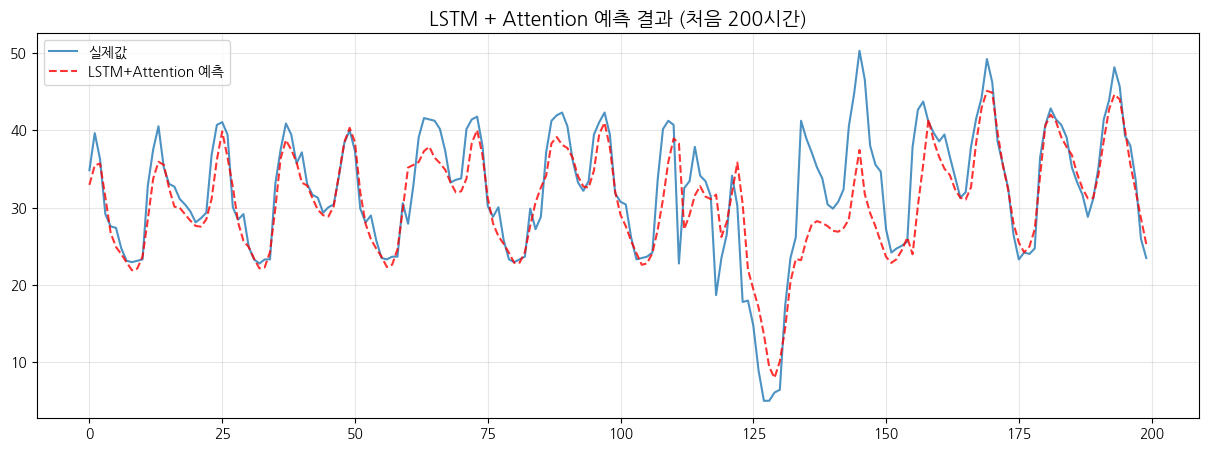

In [74]:
# LSTM + Attention 예측 시각화
plt.figure(figsize=(15, 5))
plt.plot(lstm_actual[:200], label='실제값', alpha=0.8)
plt.plot(attn_pred[:200], label='LSTM+Attention 예측', linestyle='--', alpha=0.8, color='red')
plt.title('LSTM + Attention 예측 결과 (처음 200시간)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### LSTM + Attention 결과 해석

**모델 특성:**
- **Attention 메커니즘**: 입력 시퀀스의 중요한 부분에 가중치 부여
- LSTM의 모든 hidden state를 활용하여 context vector 생성
- 시계열에서 **중요한 시점**을 자동으로 식별

**예측 결과 분석:**
- 기본 LSTM 대비 **특정 패턴에 집중** 가능
- Attention weights 시각화로 모델 해석 가능
- 불규칙한 패턴이나 이상치가 있는 데이터에 효과적

**Attention의 장점:**
1. **해석 가능성**: 어떤 시점이 예측에 중요한지 확인 가능
2. **장기 의존성**: 멀리 떨어진 시점도 직접 참조 가능
3. **유연성**: 다양한 길이의 입력 처리 용이

### LSTM + Attention 파라미터 조정 가이드

| 파라미터 | 현재값 | 조정 범위 | 설명 |
|---------|--------|----------|------|
| **hidden_size** | 64 | 64~256 | Attention에서 더 큰 hidden 권장 |
| **num_layers** | 2 | 2~3 | Attention 추가로 표현력 확보됨 |
| **attention_dim** | hidden_size | 32~128 | Attention 내부 차원 |

**성능 향상 팁:**
1. **Multi-head Attention**: 여러 관점에서 attention 계산
2. **Positional Encoding**: 위치 정보 명시적 추가
3. **Self-Attention**: Transformer 스타일로 확장

```python
# Attention 가중치 시각화
def visualize_attention(model, X):
    model.eval()
    with torch.no_grad():
        lstm_out, _ = model.lstm(X)
        _, attn_weights = model.attention(lstm_out)
    
    plt.figure(figsize=(12, 4))
    plt.imshow(attn_weights[0].squeeze().numpy(), aspect='auto', cmap='hot')
    plt.colorbar(label='Attention Weight')
    plt.xlabel('Time Step')
    plt.title('Attention Weights Visualization')
    plt.show()
```

---

# Part 5.8 Foundation Model - Chronos

Chronos는 Amazon에서 개발한 시계열 Foundation 모델입니다. 사전학습된 모델을 사용하여 Zero-shot 예측이 가능합니다.

In [75]:
# Chronos 설치
!pip install chronos-forecasting -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.1 MB/s eta 0:00:00


In [76]:
from chronos import ChronosPipeline

# Chronos 모델 로드 (tiny 버전 사용 - 더 빠름)
print("Chronos 모델 로딩 중...")
chronos_pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="auto",
    torch_dtype=torch.float32,
)
print("✅ Chronos 모델 로드 완료!")

Chronos 모델 로딩 중...


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

✅ Chronos 모델 로드 완료!


In [77]:
# 예측
context = torch.tensor(train.values, dtype=torch.float32) # 힌트: torch.tensor(데이터, dtype=torch.float32)
prediction_length = len(test)

print(f"예측 기간: {prediction_length}시간")
chronos_forecast = chronos_pipeline.predict(
    context,
    prediction_length,
    num_samples=20,  # 샘플 수
)

# 중앙값을 예측값으로 사용
chronos_pred = np.median(chronos_forecast.numpy(), axis=1).flatten()

# 평가
result = evaluate_model(test.values, chronos_pred, 'Chronos (Foundation)')
results.append(result)

예측 기간: 1018시간

모델: Chronos (Foundation)
RMSE: 7.8810
MAE:  6.7881
MAPE: 19.27%


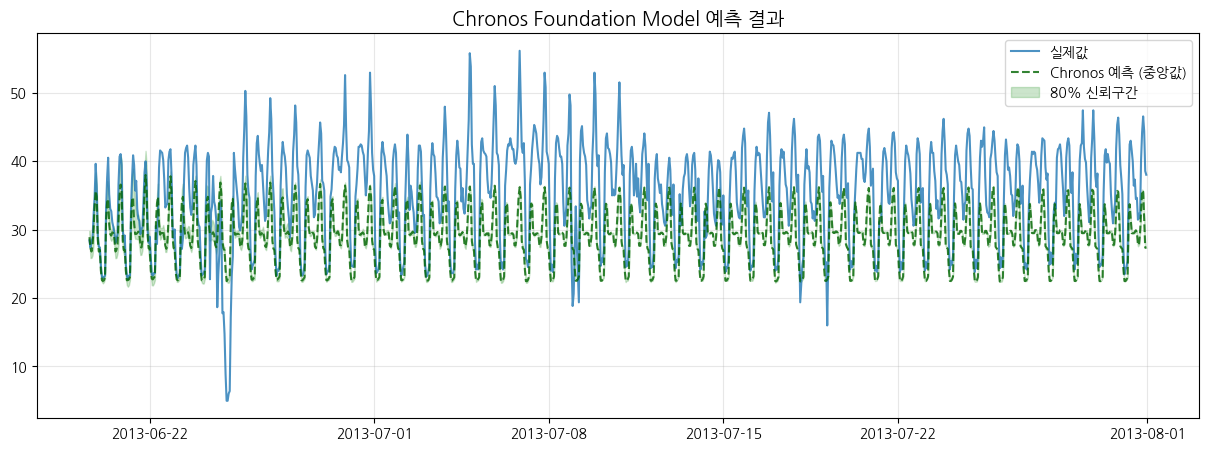

In [78]:
# Chronos 예측 시각화 (불확실성 포함)
plt.figure(figsize=(15, 5))

# 예측 분위수 계산
low = np.percentile(chronos_forecast.numpy(), 10, axis=1).flatten()
high = np.percentile(chronos_forecast.numpy(), 90, axis=1).flatten()

plt.plot(test.index, test.values, label='실제값', alpha=0.8)
plt.plot(test.index, chronos_pred, label='Chronos 예측 (중앙값)', linestyle='--', alpha=0.8, color='darkgreen')
plt.fill_between(test.index, low, high, alpha=0.2, color='green', label='80% 신뢰구간')
plt.title('Chronos Foundation Model 예측 결과', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Chronos 결과 해석

**모델 특성:**
- **Foundation Model**: 대규모 시계열 데이터로 사전학습된 모델
- Amazon에서 개발한 **Zero-shot 시계열 예측** 모델
- 별도 학습 없이 바로 예측 가능 (Pre-trained)

**예측 결과 분석:**
- **확률적 예측**: 불확실성(신뢰구간)을 함께 제공
- 다양한 도메인의 시계열에 **범용적으로 적용** 가능
- 특히 데이터가 적거나 새로운 도메인에서 강점

**장점:**
1. 학습 시간 Zero (사전학습 모델 사용)
2. 불확실성 추정 기능 내장
3. 다양한 주기, 패턴에 대응 가능

**한계점:**
- 특정 도메인에 fine-tuning하면 더 좋은 성능 가능
- 모델 크기에 따른 추론 시간 차이

### Chronos 파라미터 조정 가이드

| 파라미터 | 현재값 | 옵션 | 설명 |
|---------|--------|------|------|
| **model_size** | tiny | tiny, small, base, large | 모델 크기 (성능↔속도 트레이드오프) |
| **num_samples** | 20 | 10~100 | 예측 샘플 수 (많을수록 정확한 불확실성 추정) |
| **prediction_length** | len(test) | 데이터 특성 | 예측 기간 |

**모델 크기별 특성:**
| 모델 | 파라미터 | 권장 상황 |
|------|----------|----------|
| chronos-t5-tiny | 8M | 빠른 실험, 프로토타이핑 |
| chronos-t5-small | 20M | 일반적인 사용 |
| chronos-t5-base | 200M | 높은 정확도 필요 시 |
| chronos-t5-large | 710M | 최고 성능, GPU 필수 |

```python
# 불확실성 활용 예측
low, median, high = np.percentile(chronos_forecast.numpy(), [10, 50, 90], axis=1)

plt.fill_between(range(len(median.flatten())),
                 low.flatten(), high.flatten(),
                 alpha=0.3, label='80% 신뢰구간')
plt.plot(median.flatten(), label='예측 중앙값')
```

---

# Part 6. TFT (Temporal Fusion Transformer)

TFT는 pytorch-forecasting 라이브러리를 사용합니다.

## 6.1 TFT용 데이터 준비

In [79]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet, Baseline
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

In [80]:
# TFT용 데이터프레임 준비
df_tft = df[['power_usage', 'hour', 'day', 'day_of_week', 'month']].copy()
df_tft['time_idx'] = range(len(df_tft))
df_tft['group_id'] = 'MT_004'  # 단일 그룹

# 학습/검증 분할점
max_encoder_length = 24 * 7  # 1주일 입력
max_prediction_length = 24   # 24시간 예측
training_cutoff = df_tft['time_idx'].max() - max_prediction_length

print(f"Time index 범위: 0 ~ {df_tft['time_idx'].max()}")
print(f"Training cutoff: {training_cutoff}")

Time index 범위: 0 ~ 5087
Training cutoff: 5063


## 6.2 TimeSeriesDataSet 생성

In [81]:
# Training dataset
training = TimeSeriesDataSet(
    df_tft[df_tft.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='power_usage',
    group_ids=['group_id'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['group_id'],
    time_varying_known_reals=['time_idx', 'hour', 'day', 'day_of_week', 'month'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(groups=['group_id'], transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Validation dataset
validation = TimeSeriesDataSet.from_dataset(training, df_tft, predict=True, stop_randomization=True)

# DataLoaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

print(f"\n✅ DataLoader 생성 완료")
print(f"Training samples: {len(training)}")
print(f"Validation samples: {len(validation)}")


✅ DataLoader 생성 완료
Training samples: 5087
Validation samples: 1


## 6.3 Baseline 모델 (기준선)

In [82]:
# Baseline 모델로 기준 MAE 계산
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).cpu()
baseline_predictions = Baseline().predict(val_dataloader)
baseline_mae = (actuals - baseline_predictions).abs().mean().item()

print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"\nTFT 모델은 이 값보다 낮아야 합니다!")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 5.6084

TFT 모델은 이 값보다 낮아야 합니다!


## 6.4 TFT 모델 학습

In [83]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=True, mode='min')
lr_monitor = LearningRateMonitor()

# Trainer
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[lr_monitor, early_stop],
    enable_progress_bar=True,
)

# TFT 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=32,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles
    loss=QuantileLoss(), # Quantile Loss 사용
    reduce_on_plateau_patience=3,
)

print(f"\nTFT 모델 파라미터 수: {sum(p.numel() for p in tft.parameters()):,}")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores



TFT 모델 파라미터 수: 85,076


In [84]:
# 학습
print("\nTFT 모델 학습 시작...")
trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



TFT 모델 학습 시작...


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 320    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.9 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.246
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.246


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.894 >= min_delta = 0.0001. New best score: 1.352
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.894 >= min_delta = 0.0001. New best score: 1.352


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.293 >= min_delta = 0.0001. New best score: 1.059
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.293 >= min_delta = 0.0001. New best score: 1.059


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.064 >= min_delta = 0.0001. New best score: 0.995
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.064 >= min_delta = 0.0001. New best score: 0.995


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.136 >= min_delta = 0.0001. New best score: 0.859
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.136 >= min_delta = 0.0001. New best score: 0.859


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.200 >= min_delta = 0.0001. New best score: 0.659
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.200 >= min_delta = 0.0001. New best score: 0.659


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.652
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.652


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.041 >= min_delta = 0.0001. New best score: 0.611
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0001. New best score: 0.611


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.043 >= min_delta = 0.0001. New best score: 0.568
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.0001. New best score: 0.568


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 0.568. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.568. Signaling Trainer to stop.
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## 6.5 TFT 예측 및 평가

In [85]:
# 최적 모델 로드
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# 예측
tft_predictions = best_tft.predict(val_dataloader)
actuals_cpu = actuals.cpu().numpy()
predictions_cpu = tft_predictions.cpu().numpy() if isinstance(tft_predictions, torch.Tensor) else tft_predictions

# MAE 계산
tft_mae = np.abs(actuals_cpu - predictions_cpu).mean()
print(f"\nTFT MAE: {tft_mae:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"개선율: {(baseline_mae - tft_mae) / baseline_mae * 100:.2f}%")

# 결과 저장
results.append({'model': 'TFT', 'RMSE': np.nan, 'MAE': tft_mae, 'MAPE': np.nan})

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



TFT MAE: 1.2168
Baseline MAE: 5.6084
개선율: 78.30%


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


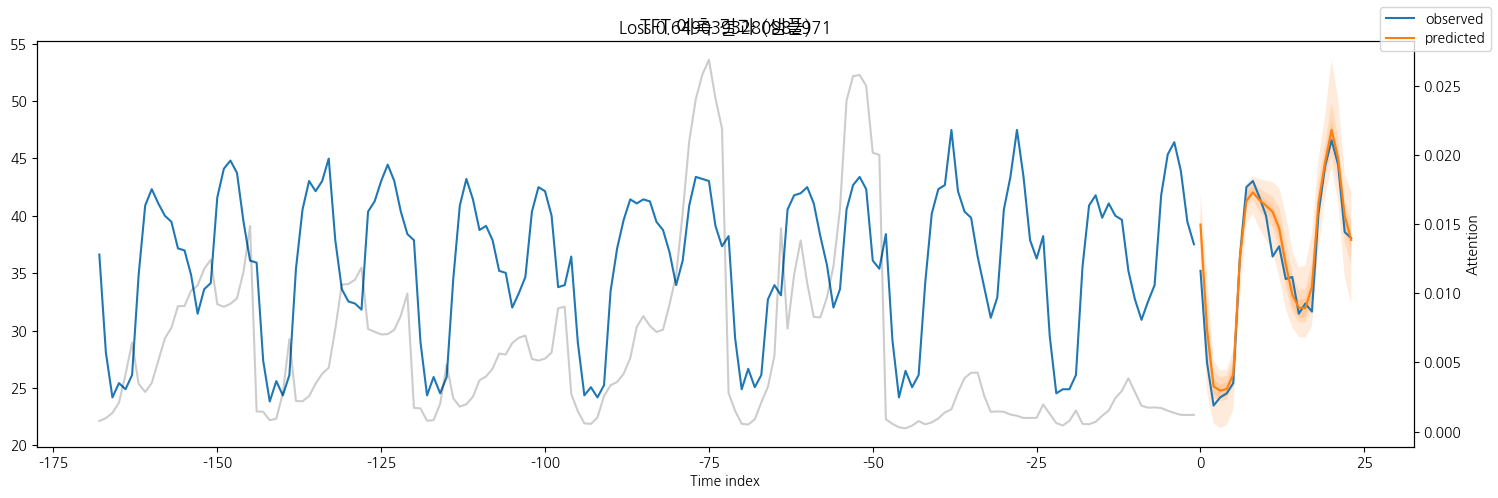

In [87]:
# TFT 예측 시각화
raw_predictions = best_tft.predict(val_dataloader, mode='raw', return_x=True)

# 첫 번째 샘플 시각화
fig, ax = plt.subplots(figsize=(15, 5))
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=QuantileLoss(), ax=ax)
plt.title('TFT 예측 결과 (샘플)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


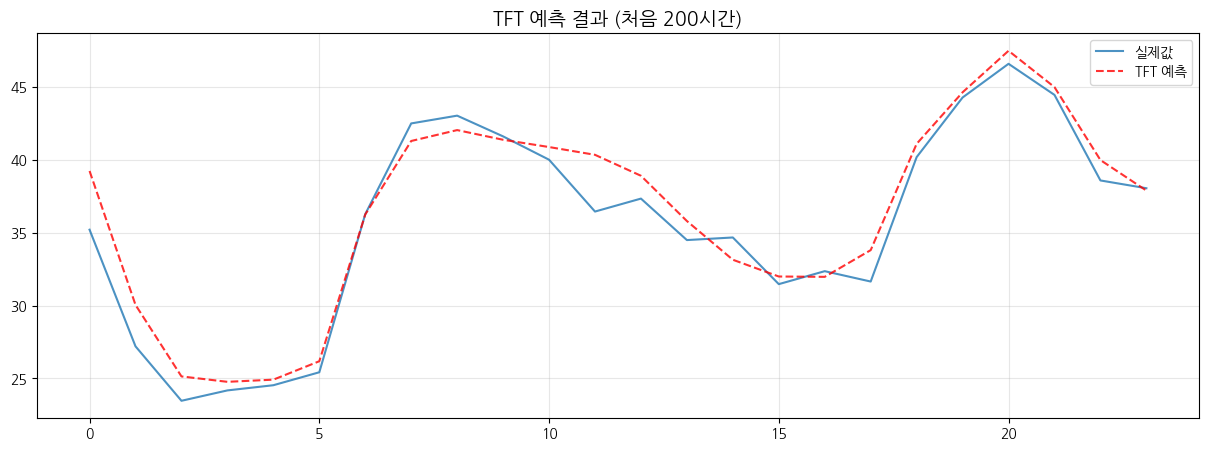

In [88]:
# TFT 예측값 추출
raw_predictions = best_tft.predict(val_dataloader, mode='raw', return_x=True)

# 예측값 추출 (중앙값 사용)
tft_pred = raw_predictions.output.prediction[:, :, 3].flatten().cpu().numpy()

# 실제값 추출
tft_actual = torch.cat([y[0] for x, y in iter(val_dataloader)]).flatten().cpu().numpy()

# 스케일 복원이 필요한 경우
# tft_pred = scaler.inverse_transform(tft_pred.reshape(-1, 1)).flatten()
# tft_actual = scaler.inverse_transform(tft_actual.reshape(-1, 1)).flatten()

# 단순 시각화
plt.figure(figsize=(15, 5))
plt.plot(tft_actual[:200], label='실제값', alpha=0.8)
plt.plot(tft_pred[:200], label='TFT 예측', linestyle='--', alpha=0.8, color='red')
plt.title('TFT 예측 결과 (처음 200시간)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### TFT 결과 해석

**모델 특성:**
- **Temporal Fusion Transformer**: 시계열 전용 Transformer 아키텍처
- **다양한 입력 지원**: 정적 특성, 시간 특성, 과거/미래 특성 모두 활용
- **해석 가능성**: Variable Selection Network로 중요 변수 식별

**예측 결과 분석:**
- 복잡한 다변량 시계열에서 **최고 수준의 성능**
- Quantile 예측으로 **불확실성 추정** 가능
- 시간대별, 변수별 중요도를 해석할 수 있음

**TFT의 핵심 구성요소:**
1. **Variable Selection Network**: 중요 변수 자동 선택
2. **Gated Residual Network**: 비선형 처리 + Skip connection
3. **Multi-head Attention**: 시간적 패턴 학습
4. **Quantile Output**: 확률적 예측

### TFT 파라미터 조정 가이드

| 파라미터 | 현재값 | 조정 범위 | 효과 |
|---------|--------|----------|------|
| **hidden_size** | 32 | 16~128 | 모델 용량, 과적합 위험 |
| **attention_head_size** | 2 | 1~4 | Multi-head attention 수 |
| **dropout** | 0.1 | 0.1~0.3 | 과적합 방지 |
| **hidden_continuous_size** | 16 | 8~32 | 연속 변수 임베딩 차원 |
| **learning_rate** | 0.001 | 1e-4~1e-2 | 학습 속도 |
| **max_encoder_length** | 48 | 24~168 | 입력 시퀀스 길이 |
| **max_prediction_length** | 24 | 12~48 | 예측 기간 |

**성능 향상 팁:**
1. **특성 엔지니어링**: hour, dayofweek, month 등 시간 특성 추가
2. **외부 변수**: 날씨, 공휴일 등 관련 변수 추가
3. **Learning Rate Finder**: 최적 학습률 탐색
4. **Early Stopping**: validation loss 기반 조기 종료

```python
# Learning Rate Finder 사용
from lightning.pytorch.tuner import Tuner

tuner = Tuner(trainer)
res = tuner.lr_find(tft, train_dataloaders=train_dataloader,
                    val_dataloaders=val_dataloader)
print(f"추천 학습률: {res.suggestion()}")

# 중요 변수 분석
interpretation = best_tft.interpret_output(predictions)
for key, value in interpretation.items():
    print(f"{key}: {value}")
```

---

# Part 7. 모델 성능 비교 및 결론

In [89]:
# 결과 DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAE')

print("\n" + "="*60)
print("모델 성능 비교 (MAE 기준 오름차순)")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


모델 성능 비교 (MAE 기준 오름차순)
                        model     RMSE      MAE      MAPE
                          TFT      NaN 1.216782       NaN
                          GRU 2.975008 2.158223  6.572342
               LSTM+Attention 3.194261 2.265619  6.877699
                   Simple RNN 3.365076 2.437578  7.134878
                         LSTM 3.708670 2.804699  8.358212
         Chronos (Foundation) 7.881048 6.788056 19.270605
               ARIMA(2, 1, 1) 8.387849 7.173873 21.684155
SARIMA(2, 1, 2)x(1, 1, 1, 24) 8.487904 7.674347 22.298856
                 Holt-Winters 9.430326 8.476833 24.148230


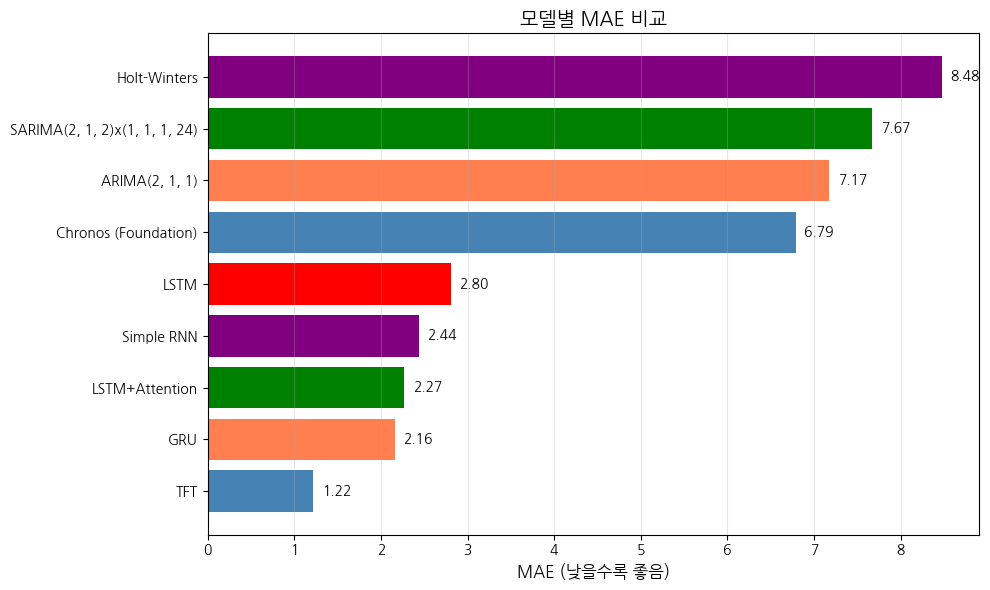

In [90]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['steelblue', 'coral', 'green', 'purple', 'red']
ax.barh(results_df['model'], results_df['MAE'], color=colors[:len(results_df)])
ax.set_xlabel('MAE (낮을수록 좋음)', fontsize=12)
ax.set_title('모델별 MAE 비교', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (model, mae) in enumerate(zip(results_df['model'], results_df['MAE'])):
    if not pd.isna(mae):
        ax.text(mae + 0.1, i, f'{mae:.2f}', va='center')

plt.tight_layout()
plt.show()

## 결론 및 모델 적합성 평가

### 모델별 특징

| 모델 | 유형 | 장점 | 단점 | 적합한 경우 |
|------|------|------|------|-------------|
| **ARIMA** | 전통 | 간단, 해석 용이 | 계절성 미반영 | 단순 추세 데이터 |
| **SARIMA** | 전통 | 계절성 반영 | 계산 시간 오래 걸림 | 명확한 주기 패턴 |
| **Holt-Winters** | 전통 | 빠른 학습, 계절성 반영 | 복잡한 패턴 한계 | 추세+계절성 데이터 |
| **VAR** | 전통 | 다변량 분석 가능 | 변수 간 관계 필요 | 다변량 시계열 |
| **Simple RNN** | 딥러닝 | 구조 단순 | Vanishing gradient | 짧은 시퀀스 |
| **LSTM** | 딥러닝 | 장기 의존성 학습 | 많은 데이터 필요 | 복잡한 시계열 |
| **GRU** | 딥러닝 | LSTM보다 빠름 | LSTM보다 표현력 낮음 | 중간 복잡도 |
| **LSTM+Attention** | 딥러닝 | 중요 시점 집중 | 계산 복잡도 증가 | 핵심 패턴 포착 |
| **TFT** | Transformer | 해석 가능, 외생 변수 | 복잡한 설정 | 다변량, 장기 예측 |
| **Chronos** | Foundation | Zero-shot, 범용성 | GPU 필요 | 빠른 프로토타이핑 |

### 전력 소비 데이터에 대한 권장사항

1. **빠른 구현이 필요한 경우**: Holt-Winters, SARIMA, 또는 Chronos
2. **높은 정확도가 필요한 경우**: TFT, LSTM+Attention, 또는 GRU
3. **해석 가능성이 중요한 경우**: TFT (변수 중요도 제공)
4. **다변량 분석이 필요한 경우**: VAR 또는 TFT
5. **학습 데이터가 부족한 경우**: Chronos (Foundation Model)

---

# 과제 완료!

## 학습 내용 정리

1. **시계열 전처리**: 결측치 처리, 리샘플링, 특성 공학
2. **정상성 검정**: ADF/KPSS 검정, 차분을 통한 정상성 확보
3. **전통 모델**: ARIMA, SARIMA, Holt-Winters, VAR 적용 및 비교
4. **RNN 계열**: Simple RNN, LSTM, GRU 구현 및 비교
5. **Attention 메커니즘**: LSTM + Attention 구현
6. **Transformer 기반**: TFT 구현 및 학습
7. **Foundation 모델**: Chronos를 활용한 Zero-shot 예측
8. **모델 평가**: RMSE, MAE, MAPE를 통한 성능 비교